# Probe behavioral data

Also consider this a data check:
- is the number of completions consistent across experiment arms?
- what is the overall share rate?
- how does the share rate differ by experiment arm?

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Downloaded from Qualtrics indicated by date in filename
# This data was filtered to responses that were considered completed (included attention check at the end)
# data_filepath = '../data/amazon-purchases-survey-v0-completed-11-30-2022-raw.csv'
# data_filepath = '../data/amazon-purchases-survey-v0-completed-11-22-2022-raw.csv'
# This datafile downloaded to only include data from Prolific participants who passed the attention check
# data_filepath = '../data/amazon-purchases-survey-v0-completed-12-08-2022-raw.csv'
data_filepath = '../data/amazon-purchases-survey-v0-completed-1-10-2023-raw.csv'

In [2]:
pd.set_option('max_columns', None)

df = pd.read_csv(data_filepath)
print('shape:', df.shape)
print('all fields:', df.columns)
df.head(2)

shape: (3321, 93)
all fields: Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q43_Id', 'Q43_Name', 'Q43_Size',
       'Q43_Type', 'Q-requirements-1', 'Q-requirements-2', 'intro-1',
       'intro-2', 'Q-prolific', 'Q-prolific-mturk', 'Q-mturk-account',
       'Q-accnt-attn-check', 'download', 'download-fail-expl',
       'download-fail-screen_Id', 'download-fail-screen_Name',
       'download-fail-screen_Size', 'download-fail-screen_Type', 'q-demos-age',
       'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-education',
       'Q-demos-income', 'Q-demos-gender', 'Q-sexual-orientation',
       'Q-demos-state', 'Q-amazon-use-howmany', 'Q-amazon-use-hh-size',
       'Q-amazon-use-how-oft', 'Q-substance-use_1', 'Q-substanc

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,Q43_Id,Q43_Name,Q43_Size,Q43_Type,Q-requirements-1,Q-requirements-2,intro-1,intro-2,Q-prolific,Q-prolific-mturk,Q-mturk-account,Q-accnt-attn-check,download,download-fail-expl,download-fail-screen_Id,download-fail-screen_Name,download-fail-screen_Size,download-fail-screen_Type,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,Q-sexual-orientation,Q-demos-state,Q-amazon-use-howmany,Q-amazon-use-hh-size,Q-amazon-use-how-oft,Q-substance-use_1,Q-substance-use_2,Q-substance-use_3,Q-personal_1,Q-personal_2,Q-life-changes,Q-data-download,Q-share-error-1,Q-share-error-2-a,Q-share-error-2-b,Q-share-error-2-c0,Q-share-error-2-c,share-error-3,share-error-4_Id,share-error-4_Name,share-error-4_Size,share-error-4_Type,Q-control,Q-altruism,Q-bonus-05,Q-bonus-20,Q-bonus-50,Q-data-value-05,Q-data-value-20,Q-data-value-50,Q-data-value-100,Q-data-value-any,Q-data-value-any_1_TEXT,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Q-attn-check,Q-comments,SurveyID,ResponseID,FQID,API_TOKEN,BATCH,RandomID,PROLIFIC_PID,STUDY_ID,SESSION_ID,showdata,incentive,consent
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,Recipient First Name,Recipient Email,External Data Reference,Location Latitude,Location Longitude,Distribution Channel,User Language,Hidden file upload question [QID47-UploadedFil...,Hidden file upload question [QID47-UploadedFil...,Hidden file upload question [QID47-UploadedFil...,Hidden file upload question [QID47-UploadedFil...,Do you have an active Amazon account?,Have you used your Amazon account to make purc...,Introduction\n\n \nThis survey is part of a MI...,Survey questions and data collection\n\nWe wil...,What is your Prolific ID?,Do you also complete surveys (or HITs) using A...,Is the Amazon.com account that you use to comp...,"Since you have different Amazon accounts, will...",Start the data download process\n\n \nGo to th...,Please explain below why you were not able to ...,Upload a screenshot displaying the issue here....,Upload a screenshot displaying the issue here....,Upload a screenshot displaying the issue here....,Upload a screenshot displaying the issue here....,What is your age group?,"Are you of Spanish, Hispanic, or Latino origin?",Choose one or more races that you consider you...,What is the highest level of education you hav...,What was your total household income before ta...,How do you describe yourself?,Which best describes your sexual orientation?,"50 States, D.C. and Puerto Rico",How many people do you share your Amazon accou...,"How many people are in your ""household""?",How often do you (+ anyone you share your acco...,Are any of the following the case for:\n\nYou ...,Are any of the following the case for:\n\nYou ...,Are any of the following the case for:\n\nYou ...,Are any of the following the case for:\n\nYou ...,Are any of the following the case for:\n\nYou ...,"In 2021 did you, or someone you share your Ama...",Amazon data\n \n\nGo back to the Amazon page w...,What was the issue?,Do you have an active Amazon account that you ...,Can you log into that Amazon account during th...,Do you also complete surveys or HITs on Amazon...,Is the Amazon.com account that you use to comp...,Please describe the issue here.,Please upload a screenshot displaying the issu...,Please upload a screenshot displaying the issu...,Please upload a screenshot displaying the issu...,Please upload a screenshot displaying the issu...,Click to insert the file from Amazon below.\n ...,Click to insert the file from Amazon below.\n ...,Click to insert the file from Amazon below.\n ...,Click to insert the file from Amazon below.\n ...,Click to inser

Codebook

In [3]:
"""
Utility for importing into notebooks. (Move me to a library .py file)
"""

# This is a dump from the recode values exported from qualtrics Q-demos-state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}

# {QID: {Q: Q text, choices: map}}
codebook = {
    'q-demos-age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'18 - 24 years',
            '2':'25 - 34 years',
            '3':'35 - 44 years',
            '4':'45 - 54 years',
            '5':'55 - 64 years',
            '6':'65 or older'
        },
    },
    'Q-demos-race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White',
            '2':'Black or African American',
            '3':'American Indian or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Pacific Islander',
            '6':'Other'
        },
    },
    'Q-demos-education': {
        'Q':'What is the highest level of education you have completed?',
        'choices': {
            '1':'Some high school or less',
            '2':'High school diploma or GED',
            '3':'Bachelor\'s degree',
            '4':'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS, etc)',
            '5':'Prefer not to say'
        }
        
    },
    'Q-demos-income': {
        'Q': 'What was your total household income in the previous year before taxes?',
        'choices': {
            '1':'Less than \$25,000','2':'\$25,000 to \$49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to \$99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 or more',
            '7':'Prefer not to say',
        },
    },
    'Q-demos-gender': {
        'Q':'How do you describe yourself?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to say'},
    },
    'Q-sexual-orientation': {
      'Q':'Which best describes your sexual orientation?',
        'choices':{
            '1':'heterosexual (straight)',
            '2':'LGBTQ+',
            '3':'prefer not to say'
        },
    },
    'Q-demos-state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
    'Q-amazon-use-how-oft': {
        'Q': 'How often do you (+ anyone you share your account with) order deliveries from Amazon?',
        'choices': {
            '1': 'Less than 5 times per month',
            '2': '5 - 10 times per month',
            '3': 'More than 10 times per month'
        }
    }
}


In [4]:
# Drop the Qualtrics metadata
df = df.drop([0,1])

## Sharing behavior

Set up dataframe to have boolean indicating whether participant shared

In [5]:
df[
    ['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'showdata', 'incentive']
].head()

,Q-control,Q-altruism,Q-bonus-05,Q-bonus-20,Q-bonus-50,showdata,incentive
2,NaN,NaN,NaN,1,NaN,false,bonus-20
3,NaN,NaN,NaN,NaN,1,true,bonus-50
4,NaN,1,NaN,NaN,NaN,false,altruism
5,NaN,NaN,1,NaN,NaN,true,bonus-05
6,NaN,NaN,NaN,1,NaN,false,bonus-20


In [6]:
# add boolean indicating share
df['share'] = df[
    ['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50']
].astype(float).fillna(0).sum(axis=1)
# rename incentives
df['incentive'] = df['incentive'].map({
    'control':'control', 'altruism':'altruism',
    'bonus-05':'bonus $.05', 'bonus-20':'bonus $.20', 'bonus-50':'bonus $.50'
})
df[['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'showdata', 'incentive', 'share']].head()

,Q-control,Q-altruism,Q-bonus-05,Q-bonus-20,Q-bonus-50,showdata,incentive,share
2,NaN,NaN,NaN,1,NaN,false,bonus $.20,1.0
3,NaN,NaN,NaN,NaN,1,true,bonus $.50,1.0
4,NaN,1,NaN,NaN,NaN,false,altruism,1.0
5,NaN,NaN,1,NaN,NaN,true,bonus $.05,1.0
6,NaN,NaN,NaN,1,NaN,false,bonus $.20,1.0


Aggregate the data

Make a table:

```
incentive, showdata, count, share rate
```

In [7]:
def get_aggregate_share_df(df):
    return df.groupby(['incentive','showdata'])['share'].agg(['count','mean']).round(3).reset_index()

In [8]:
agg_share_df = get_aggregate_share_df(df)
agg_share_df

,incentive,showdata,count,mean
0,altruism,false,334,0.766
1,altruism,true,346,0.841
2,bonus $.05,false,340,0.726
3,bonus $.05,true,316,0.807
4,bonus $.20,false,340,0.779
5,bonus $.20,true,326,0.871
6,bonus $.50,false,332,0.867
7,bonus $.50,true,327,0.905
8,control,false,314,0.783
9,control,true,344,0.826


In [9]:
# overall
N = agg_share_df['count'].sum()
overall_share_rate = df['share'].mean().round(3)

print('N = %s' % N)
print('overall share rate: %s' % overall_share_rate)

N = 3319
overall share rate: 0.817


In [10]:
# What about for just the control condition?
def get_control_df(df=df):
    return df[df['incentive']=='control']
control_df = get_control_df(df)
control_N = len(control_df)
control_share_rate = control_df['share'].mean().round(3)
print('control N = %s' % control_N)
print('control share rate: %s' % control_share_rate)

control N = 658
control share rate: 0.805


In [11]:
def plot_count(pdf, ax):
    width = 0.4
    (pdf[pdf['showdata']=='true']['count']
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='show data = true',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']=='false']['count']
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='show data = false',
        ax=ax, width=width, position=0)
    )
    ax.set_ylabel('Completions')
    ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    _ = ax.set_xticklabels(pdf[pdf['showdata']=='true']['incentive'], rotation=0)

Check: is the number of completions consistent across experiment arms?

Use chi-square test of homogeneity.

Null hypothesis: Completions count is the same across experimental arms

chi-square test null hypothesis: Completions count is the same across experimental arms
chi-square test result: stat=3.353, p-value=0.949
We do not reject the null hypothesis


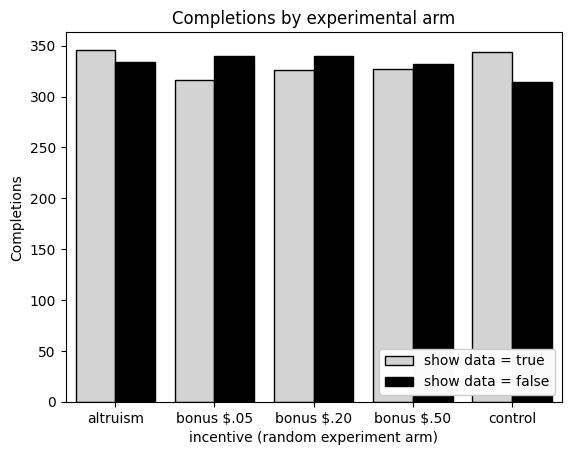

In [12]:
# plot count
fig,ax = plt.subplots(1,1)#, dpi=150)
ax.set_title('Completions by experimental arm')
plot_count(agg_share_df, ax)
# chi-square test
(statistic, pvalue) = chisquare(agg_share_df['count'])
print('chi-square test null hypothesis: Completions count is the same across experimental arms')
print('chi-square test result: stat=%0.3f, p-value=%0.3f' % (statistic, pvalue))
if pvalue > 0.05:
    print('We do not reject the null hypothesis')
else:
    print('We reject the null hypothesis')

In [13]:
def plot_share_rate(pdf, ax, overall_share_rate=overall_share_rate):
    width = 0.4
    (pdf[pdf['showdata']=='true']['mean']
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='show data = true',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']=='false']['mean']
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='show data = false',
        ax=ax, width=width, position=0)
    )
    if overall_share_rate is not None:
        ax.hlines(overall_share_rate, -1, 5, color='gray', label='overall')
    ax.set_ylabel('Share rate')
    ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    ax.set_ylim([0,1])
    _ = ax.set_xticklabels(pdf[pdf['showdata']=='true']['incentive'], rotation=0)

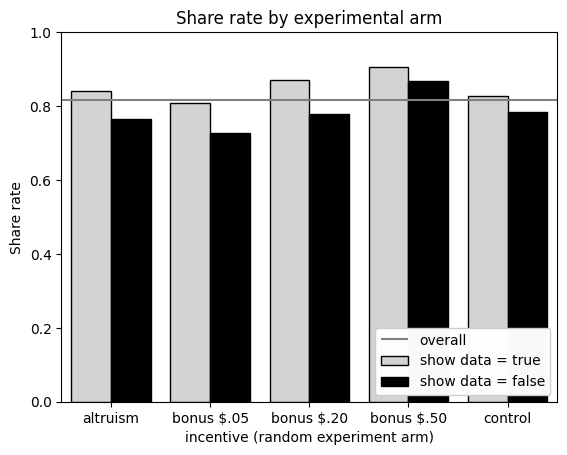

In [14]:
fig,ax = plt.subplots(1,1)#, dpi=150)
ax.set_title('Share rate by experimental arm')
plot_share_rate(agg_share_df, ax)

observations:
- showdata=true consistently higher share rate (like before, more consistent)
- incentive bonus: $0.05 has negative effect compared to control
- incentive: altruism has no noticeable effect over control

### Model

In [15]:
formula = "share ~ C(incentive, Treatment(reference='control'))"
res = smf.logit(formula=formula, data=df).fit()
print('\n',formula)
res.summary()

Optimization terminated successfully.
         Current function value: 0.470283
         Iterations 6

 share ~ C(incentive, Treatment(reference='control'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  share   No. Observations:                 3319
Model:                          Logit   Df Residuals:                     3314
Method:                           MLE   Df Model:                            4
Date:                Tue, 10 Jan 2023   Pseudo R-squ.:                 0.01147
Time:                        22:54:05   Log-Likelihood:                -1560.9
converged:                       True   LL-Null:                       -1579.0
Covariance Type:            nonrobust   LLR p-value:                 2.588e-07
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      1.4208      0.098     14.427      0.000       1.228       1.614
C(incentive, Treatment(reference='control'))[T.altruism]      -0.0067      0.138     -0.049      0.961      -0.277       0.264
C(incentive, Treatment(reference='control'))[T.bonus $.05]    -0.2392      0.135     -1.774      0.076      -0.504       0.025
C(incentive, Treatment(reference='control'))[T.bonus $.20]     0.1251      0.142      0.883      0.377      -0.153       0.403
C(incentive, Treatment(reference='control'))[T.bonus $.50]     0.6316      0.157      4.015      0.000       0.323       0.940
==============================================================================================================================
"""

In [16]:
formula = "share ~ C(showdata, Treatment(reference='true'))"
smf.logit(formula=formula, data=df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.472129
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  share   No. Observations:                 3319
Model:                          Logit   Df Residuals:                     3317
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Jan 2023   Pseudo R-squ.:                0.007594
Time:                        22:54:06   Log-Likelihood:                -1567.0
converged:                       True   LL-Null:                       -1579.0
Covariance Type:            nonrobust   LLR p-value:                 9.726e-07
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             1.7339      0.069     25.224      0.000       1.599       1.869
C(showdata, Treatment(reference='true'))[T.false]    -0.4428      0.091     -4.864      0.000      -0.621      -0.264
=====================================================================================================================
"""

In [17]:
formula = "share ~ C(incentive, Treatment(reference='control'))*showdata"
smf.logit(formula=formula, data=df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.466371
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  share   No. Observations:                 3319
Model:                          Logit   Df Residuals:                     3309
Method:                           MLE   Df Model:                            9
Date:                Tue, 10 Jan 2023   Pseudo R-squ.:                 0.01970
Time:                        22:54:06   Log-Likelihood:                -1547.9
converged:                       True   LL-Null:                       -1579.0
Covariance Type:            nonrobust   LLR p-value:                 5.032e-10
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       1.2858      0.137      9.385      0.000       1.017       1.554
C(incentive, Treatment(reference='control'))[T.altruism]                       -0.0974      0.188     -0.517      0.605      -0.467       0.272
C(incentive, Treatment(reference='control'))[T.bonus $.05]                     -0.3090      0.183     -1.687      0.092      -0.668       0.050
C(incentive, Treatment(reference='control'))[T.bonus $.20]                     -0.0236      0.189     -0.125      0.901      -0.395       0.348
C(incentive, Treatment(reference='control'))[T.bonus $.50]                      0.5929      0.212      2.796      0.005       0.177       1.009
showdata[T.true]                                                                0.2688      0.197      1.362      0.173      -0.118       0.656
C(incentive, Treatment(reference='control'))[T.altruism]:showdata[T.true]       0.2087      0.278      0.751      0.453      -0.336       0.754
C(incentive, Treatment(reference='control'))[T.bonus $.05]:showdata[T.true]     0.1848      0.272      0.679      0.497      -0.349       0.718
C(incentive, Treatment(reference='control'))[T.bonus $.20]:showdata[T.true]     0.3803      0.289      1.317      0.188      -0.186       0.946
C(incentive, Treatment(reference='control'))[T.bonus $.50]:showdata[T.true]     0.1088      0.317      0.343      0.732      -0.513       0.731
===============================================================================================================================================
"""

## By demographic groups

In [18]:
def add_n_labels(ax, values):
    for rect, val in zip(ax.patches, values):
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = 0.02
        ax.annotate(
            'n=%s'%val, 
            (x_value, y_value),
            va='center',
        )

def plot_share_by_demo(plt_df, demo_col, ax, control_only=False):
    plt_df.set_index(demo_col)['share rate'].plot.barh(
        ax=ax, 
        color='lightgray',  edgecolor='black'
    )
    ax.set_xlim([0,1])
    ax.set_xlabel('Share rate')
    ax.set_ylabel('')
    ax.set_title('Share rate by %s%s' % (demo_col, ' (control only)' if control_only else ''))
    share_rate = control_share_rate if control_only else overall_share_rate
    ax.axvline(share_rate, color='black')
    # annotate with labels
    add_n_labels(ax, plt_df['n'])

In [19]:
def get_share_rate_by_Q_df(Q, new_col_name, df=df):
    share_df = (
        df.groupby([Q])['share']
        .agg(['count','mean']).round(3).reset_index()
        .rename(columns={'count':'n', 'mean':'share rate'})
    )
    share_df[new_col_name] = share_df[Q].map(codebook[Q]['choices'])
    return share_df

### By gender

How do you describe yourself?
{'1': 'Male', '2': 'Female', '3': 'Other', '4': 'Prefer not to say'}


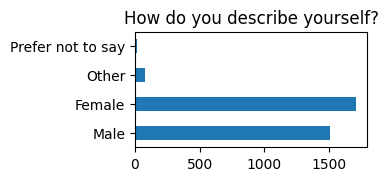

,index,count,pct
0,Male,1511,45.53
1,Female,1714,51.64
2,Other,80,2.41
3,Prefer not to say,14,0.42


In [20]:
Q = 'Q-demos-gender'
print('%s'%codebook[Q]['Q'])
print('%s'%codebook[Q]['choices'])
fig,ax = plt.subplots(figsize=(3,1.5))
ax.set_title(codebook[Q]['Q'])
_ = df[Q].value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
plt.show()
demo_df = (df[Q].value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
display(demo_df)

,Q-demos-gender,n,share rate,gender
0,1,1511,0.795,Male
1,2,1714,0.842,Female
2,3,80,0.775,Other
3,4,14,0.357,Prefer not to say


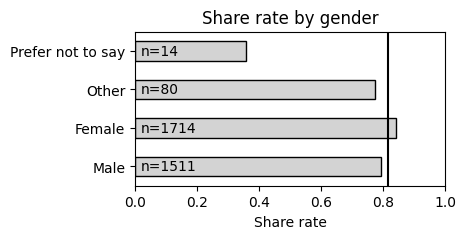

In [21]:
Q = 'Q-demos-gender'
colname = 'gender'
gender_share_df = get_share_rate_by_Q_df(Q, colname)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(gender_share_df)))
plot_share_by_demo(gender_share_df, colname, ax)
gender_share_df

,Q-demos-gender,n,share rate,gender
0,1,290,0.807,Male
1,2,349,0.814,Female
2,3,17,0.706,Other
3,4,2,0.000,Prefer not to say


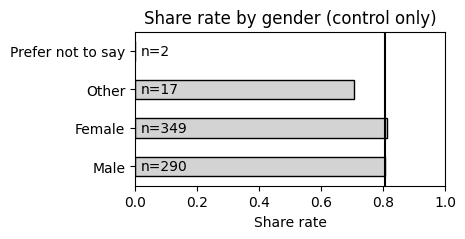

In [22]:
gender_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(gender_share_df)))
plot_share_by_demo(gender_share_df, colname, ax, control_only=True)
gender_share_df

Model: Are females significantly more likely to share versus males?

Answer: 
- Yes when we include all experimental arms
- No when just the control arm

In [23]:
Q = 'Q-demos-gender'
df['gender'] = df[Q].map(codebook[Q]['choices'])
control_df = get_control_df(df)
df[['share','gender']].head(3)

,share,gender
2,1.0,Female
3,1.0,Female
4,1.0,Female


In [24]:
# limit to just male/female
model_df = df[df['gender'].isin(['Male','Female'])]
formula = "share ~ gender"
res = smf.logit(formula=formula, data=model_df).fit()
print('\n',formula)
display(res.summary())
# check for just the control group too
res = smf.logit(formula=formula, data=get_control_df(model_df)).fit()
print('\nControl arm:\n',formula)
display(res.summary())

Optimization terminated successfully.
         Current function value: 0.469345
         Iterations 6

 share ~ gender


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  share   No. Observations:                 3225
Model:                          Logit   Df Residuals:                     3223
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Jan 2023   Pseudo R-squ.:                0.003848
Time:                        22:54:06   Log-Likelihood:                -1513.6
converged:                       True   LL-Null:                       -1519.5
Covariance Type:            nonrobust   LLR p-value:                 0.0006269
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.6724      0.066     25.261      0.000       1.543       1.802
gender[T.Male]    -0.3140      0.092     -3.415      0.001      -0.494      -0.134
==================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.485253
         Iterations 5

Control arm:
 share ~ gender


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  share   No. Observations:                  639
Model:                          Logit   Df Residuals:                      637
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Jan 2023   Pseudo R-squ.:               7.816e-05
Time:                        22:54:06   Log-Likelihood:                -310.08
converged:                       True   LL-Null:                       -310.10
Covariance Type:            nonrobust   LLR p-value:                    0.8257
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4746      0.137     10.724      0.000       1.205       1.744
gender[T.Male]    -0.0446      0.203     -0.220      0.826      -0.442       0.352
==================================================================================
"""

,incentive,showdata,count,mean
0,altruism,false,157,0.707
1,altruism,true,171,0.813
2,bonus $.05,false,160,0.725
3,bonus $.05,true,147,0.776
4,bonus $.20,false,153,0.778
5,bonus $.20,true,137,0.818
6,bonus $.50,false,142,0.838
7,bonus $.50,true,154,0.896
8,control,false,136,0.779
9,control,true,154,0.831


,incentive,showdata,count,mean
0,altruism,false,167,0.826
1,altruism,true,167,0.874
2,bonus $.05,false,174,0.730
3,bonus $.05,true,159,0.843
4,bonus $.20,false,177,0.791
5,bonus $.20,true,178,0.910
6,bonus $.50,false,179,0.894
7,bonus $.50,true,164,0.927
8,control,false,169,0.781
9,control,true,180,0.844


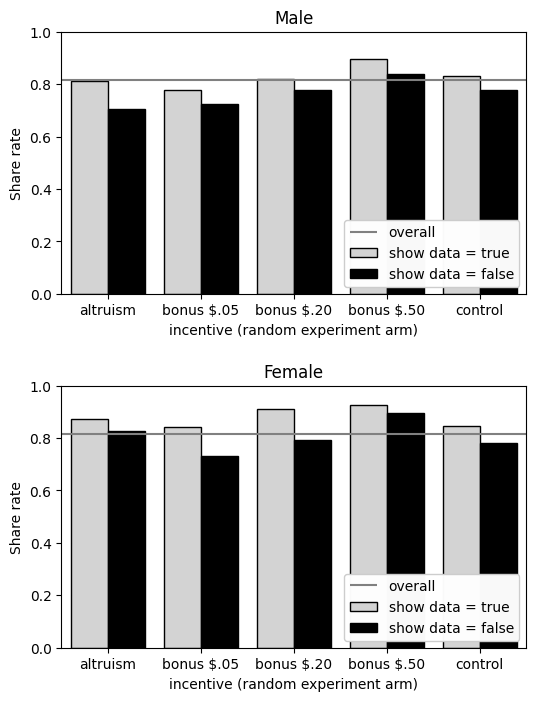

In [25]:
codebook_male_female = {'1': 'Male', '2': 'Female'}
figsize=(6,4)
fig,axes = plt.subplots(2,1,figsize=(figsize[0],figsize[1]*2))
plt.subplots_adjust(hspace=0.35)
for i, (k,v) in enumerate(codebook_male_female.items()):
    demo_df = df[df[Q]==k]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    display(demo_agg_share_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(v)

Observations:
- overall females share more
- incentive: altruism has no noticiable effect for males but seems to have positive share effect on females
- all incentives (vs control) seem to have a larger positive effect on female share rate

### By income

What was your total household income in the previous year before taxes?
{'1': 'Less than \\$25,000', '2': '\\$25,000 to \\$49,999', '3': '\\$50,000 to $74,999', '4': '\\$75,000 to \\$99,999', '5': '\\$100,000 to $149,999', '6': '\\$150,000 or more', '7': 'Prefer not to say'}


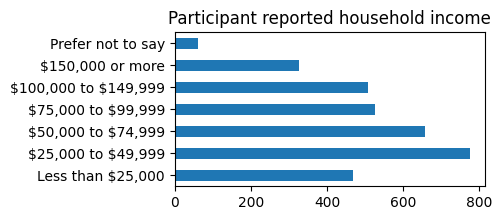

,index,count,pct
0,"Less than \$25,000",467,14.07
1,"\$25,000 to \$49,999",775,23.35
2,"\$50,000 to $74,999",657,19.80
3,"\$75,000 to \$99,999",525,15.82
4,"\$100,000 to $149,999",508,15.31
5,"\$150,000 or more",326,9.82
6,Prefer not to say,61,1.84


In [26]:
Q = 'Q-demos-income'
print('%s'%codebook[Q]['Q'])
print('%s'%codebook[Q]['choices'])
fig,ax = plt.subplots(figsize=(4,2))
_ = df[Q].value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
ax.set_title('Participant reported household income')
plt.show()
demo_df = (df[Q].value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
display(demo_df)

Q-demos-income
{'1': 'Less than \\$25,000', '2': '\\$25,000 to \\$49,999', '3': '\\$50,000 to $74,999', '4': '\\$75,000 to \\$99,999', '5': '\\$100,000 to $149,999', '6': '\\$150,000 or more', '7': 'Prefer not to say'}


,Q-demos-income,n,share rate,income
0,1,467,0.805,"Less than \$25,000"
1,2,775,0.848,"\$25,000 to \$49,999"
2,3,657,0.805,"\$50,000 to $74,999"
3,4,525,0.834,"\$75,000 to \$99,999"
4,5,508,0.831,"\$100,000 to $149,999"
5,6,326,0.779,"\$150,000 or more"
6,7,61,0.590,Prefer not to say


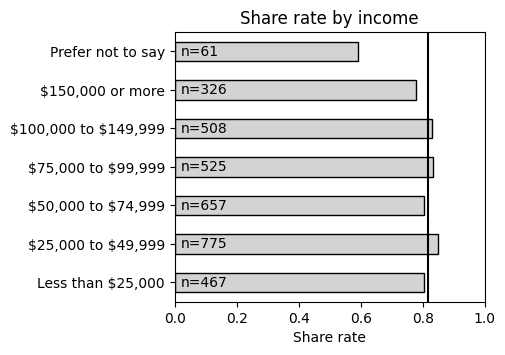

In [27]:
print(Q)
print(codebook[Q]['choices'])
colname = 'income'
income_share_df = get_share_rate_by_Q_df(Q, colname)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(income_share_df)))
plot_share_by_demo(income_share_df, colname, ax)
income_share_df

,Q-demos-income,n,share rate,income
0,1,97,0.773,"Less than \$25,000"
1,2,150,0.847,"\$25,000 to \$49,999"
2,3,115,0.809,"\$50,000 to $74,999"
3,4,107,0.804,"\$75,000 to \$99,999"
4,5,99,0.859,"\$100,000 to $149,999"
5,6,72,0.778,"\$150,000 or more"
6,7,18,0.444,Prefer not to say


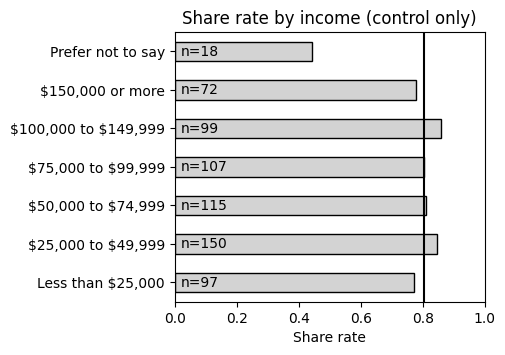

In [28]:
income_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(income_share_df)))
plot_share_by_demo(income_share_df, colname, ax, control_only=True)
income_share_df

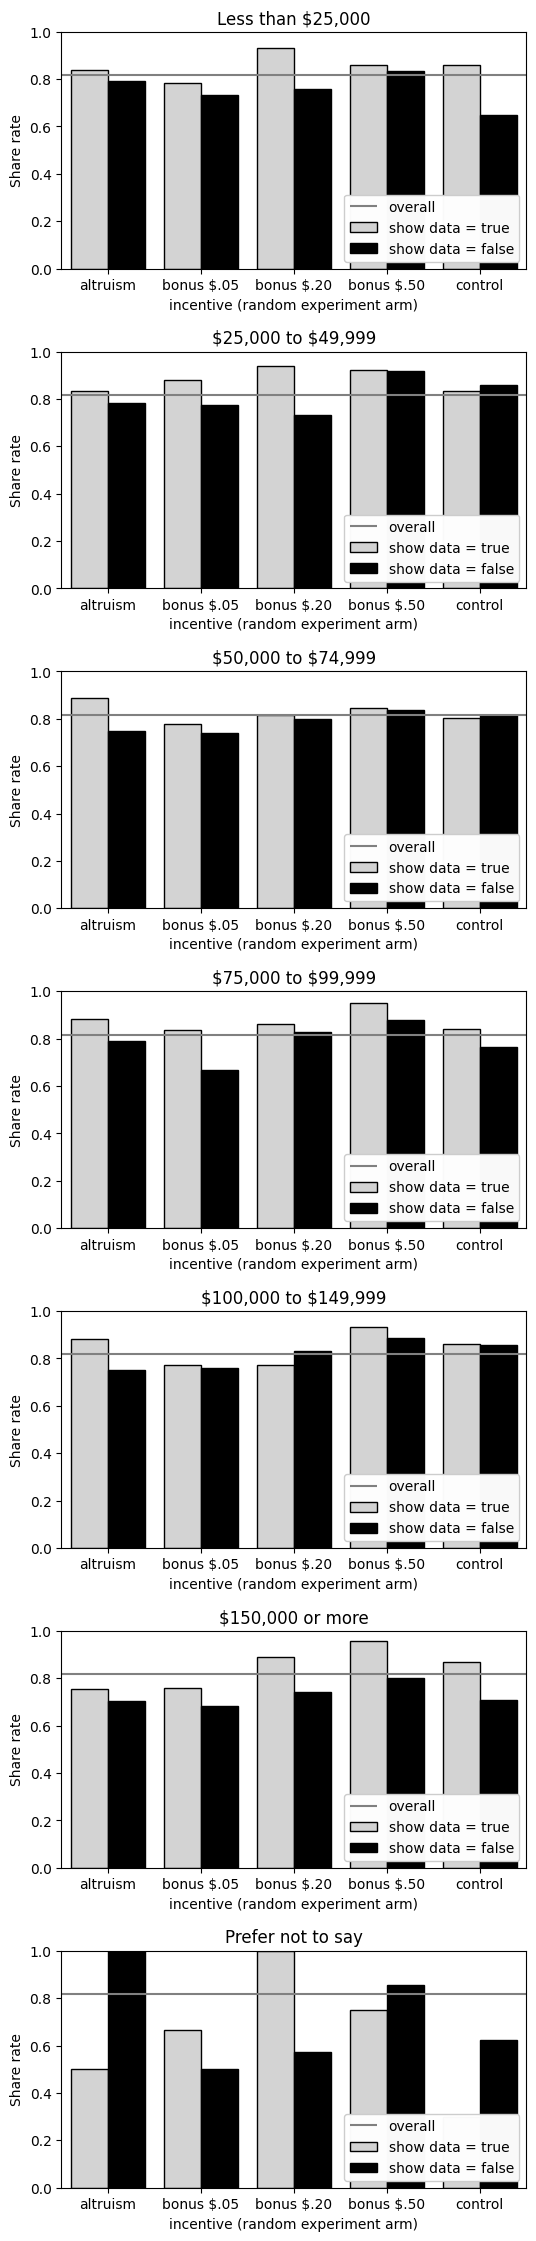

In [29]:
figsize=(6,4)
choices = codebook[Q]['choices']
fig,axes = plt.subplots(len(choices),1,figsize=(figsize[0],figsize[1]*len(choices)))
plt.subplots_adjust(hspace=0.35)
for i, (k,v) in enumerate(codebook[Q]['choices'].items()):
    demo_df = df[df[Q]==k]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    #display(demo_agg_share_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(v)

### By age

How old are you?
{'1': '18 - 24 years', '2': '25 - 34 years', '3': '35 - 44 years', '4': '45 - 54 years', '5': '55 - 64 years', '6': '65 or older'}


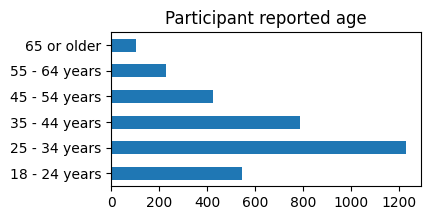

,index,count,pct
0,18 - 24 years,544,16.39
1,25 - 34 years,1231,37.09
2,35 - 44 years,788,23.74
3,45 - 54 years,424,12.77
4,55 - 64 years,229,6.90
5,65 or older,103,3.10


In [30]:
Q = 'q-demos-age'
print('%s'%codebook[Q]['Q'])
print('%s'%codebook[Q]['choices'])
fig,ax = plt.subplots(figsize=(4,2))
_ = df[Q].value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
ax.set_title('Participant reported age')
plt.show()
demo_df = (df[Q].value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
display(demo_df)

,q-demos-age,n,share rate,age
0,1,544,0.781,18 - 24 years
1,2,1231,0.803,25 - 34 years
2,3,788,0.844,35 - 44 years
3,4,424,0.833,45 - 54 years
4,5,229,0.860,55 - 64 years
5,6,103,0.816,65 or older


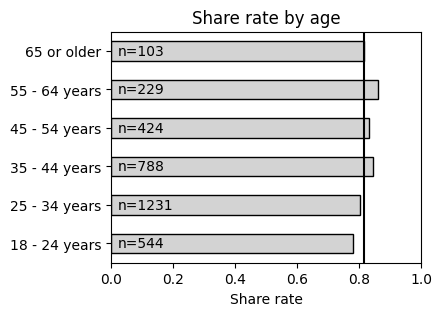

In [31]:
colname = 'age'
age_share_df = get_share_rate_by_Q_df(Q, colname)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(age_share_df)))
plot_share_by_demo(age_share_df, colname, ax)
age_share_df

,q-demos-age,n,share rate,age
0,1,106,0.679,18 - 24 years
1,2,246,0.809,25 - 34 years
2,3,140,0.864,35 - 44 years
3,4,86,0.791,45 - 54 years
4,5,54,0.833,55 - 64 years
5,6,26,0.962,65 or older


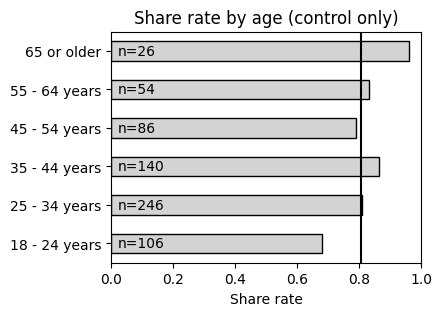

In [32]:
age_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(age_share_df)))
plot_share_by_demo(age_share_df, colname, ax, control_only=True)
age_share_df

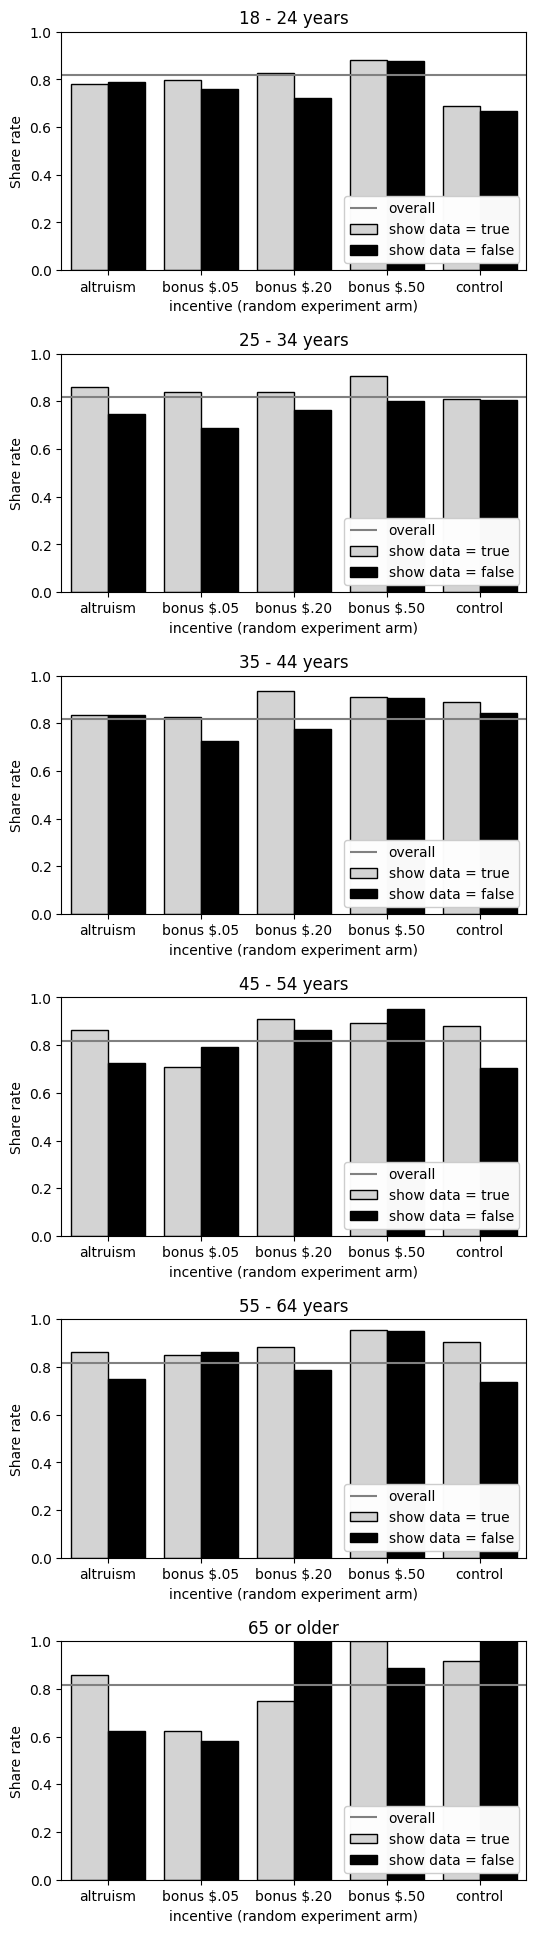

In [33]:
figsize=(6,4)
# exclude categories with N < 60
demo_df = demo_df[demo_df['count']>60]
fig,axes = plt.subplots(len(demo_df),1,figsize=(figsize[0],figsize[1]*len(demo_df)))
plt.subplots_adjust(hspace=0.35)
i = 0
for (k,v) in codebook[Q]['choices'].items():
    if v not in demo_df['index'].values:
        continue
    demo_agg_share_df = get_aggregate_share_df(df[df[Q]==k])
    #display(demo_agg_share_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(v)
    i += 1

### By education

What is the highest level of education you have completed?
{'1': 'Some high school or less', '2': 'High school diploma or GED', '3': "Bachelor's degree", '4': 'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS, etc)', '5': 'Prefer not to say'}


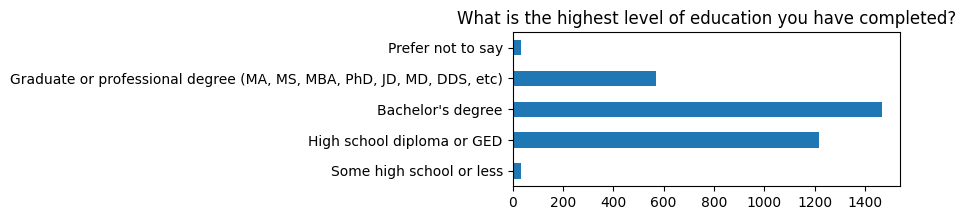

,index,count,pct
0,Some high school or less,35,1.05
1,High school diploma or GED,1216,36.64
2,Bachelor's degree,1466,44.17
3,"Graduate or professional degree (MA, MS, MBA, ...",568,17.11
4,Prefer not to say,34,1.02


In [34]:
Q = 'Q-demos-education'
print('%s'%codebook[Q]['Q'])
print('%s'%codebook[Q]['choices'])
fig,ax = plt.subplots(figsize=(5,2))
_ = df[Q].value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
ax.set_title(codebook[Q]['Q'])
plt.show()
demo_df = (df[Q].value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
display(demo_df)

,Q-demos-education,n,share rate,education
0,1,35,0.829,Some high school or less
1,2,1216,0.831,High school diploma or GED
2,3,1466,0.806,Bachelor's degree
3,4,568,0.833,"Graduate or professional degree (MA, MS, MBA, ..."
4,5,34,0.529,Prefer not to say


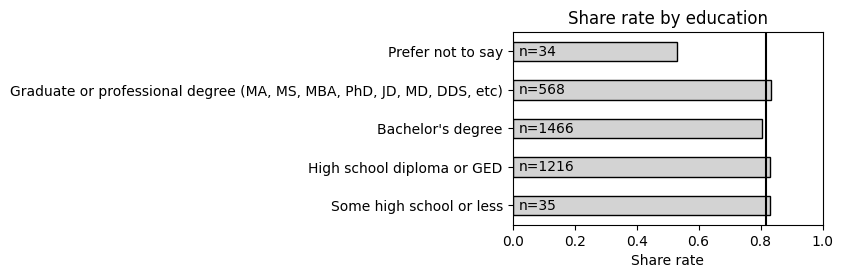

In [35]:
colname = 'education'
education_share_df = get_share_rate_by_Q_df(Q, colname)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(education_share_df)))
plot_share_by_demo(education_share_df, colname, ax)
education_share_df

,Q-demos-education,n,share rate,education
0,1,9,1.000,Some high school or less
1,2,223,0.803,High school diploma or GED
2,3,297,0.785,Bachelor's degree
3,4,121,0.868,"Graduate or professional degree (MA, MS, MBA, ..."
4,5,8,0.500,Prefer not to say


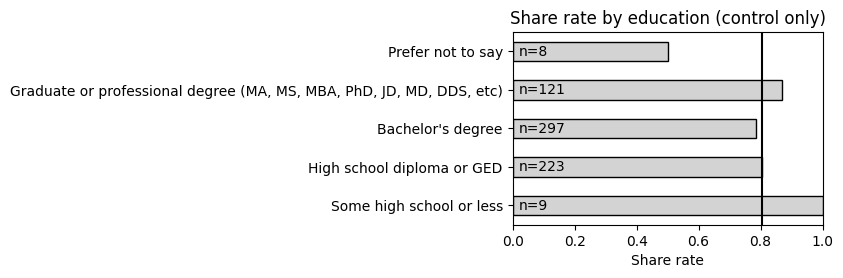

In [36]:
education_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(education_share_df)))
plot_share_by_demo(education_share_df, colname, ax, control_only=True)
education_share_df

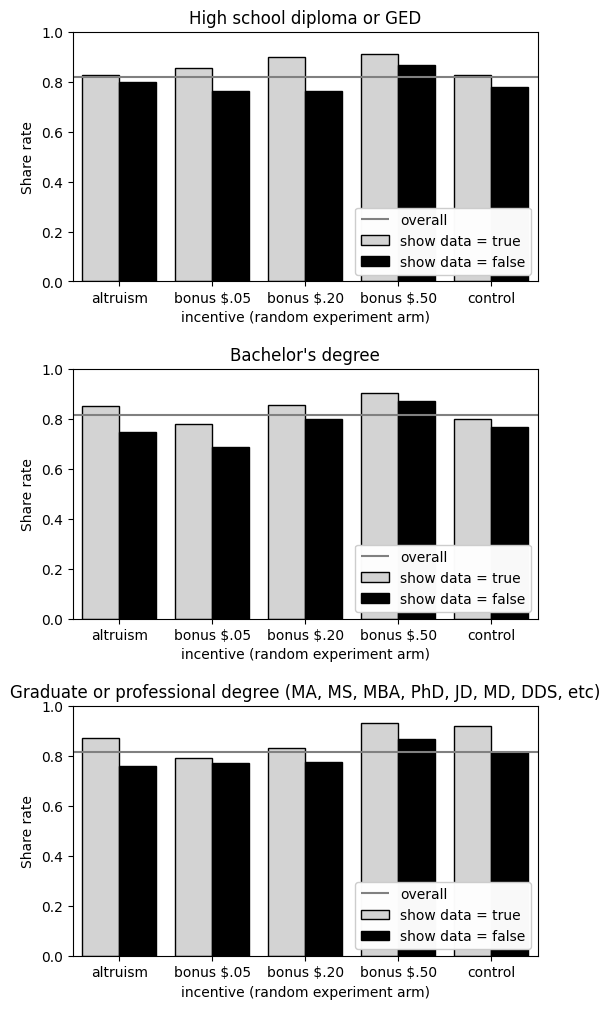

In [37]:
figsize=(6,4)
# exclude categories with N < 60
demo_df = demo_df[demo_df['count']>60]
fig,axes = plt.subplots(len(demo_df),1,figsize=(figsize[0],figsize[1]*len(demo_df)))
plt.subplots_adjust(hspace=0.35)
i = 0
for (k,v) in codebook[Q]['choices'].items():
    if v not in demo_df['index'].values:
        continue
    demo_agg_share_df = get_aggregate_share_df(df[df[Q]==k])
    #display(demo_agg_share_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(v)
    i += 1

### By sexual orientation

Which best describes your sexual orientation?
{'1': 'heterosexual (straight)', '2': 'LGBTQ+', '3': 'prefer not to say'}


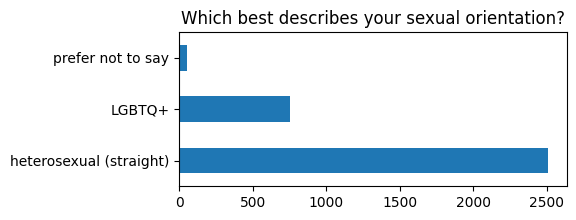

,index,count,pct
0,heterosexual (straight),2511,75.66
1,LGBTQ+,753,22.69
2,prefer not to say,55,1.66


In [38]:
Q = 'Q-sexual-orientation'
print('%s'%codebook[Q]['Q'])
print('%s'%codebook[Q]['choices'])
fig,ax = plt.subplots(figsize=(5,2))
_ = df[Q].value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
ax.set_title(codebook[Q]['Q'])
plt.show()
demo_df = (df[Q].value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
display(demo_df)

,Q-sexual-orientation,n,share rate,LGBTQ+ status
0,1,2511,0.819,heterosexual (straight)
1,2,753,0.829,LGBTQ+
2,3,55,0.564,prefer not to say


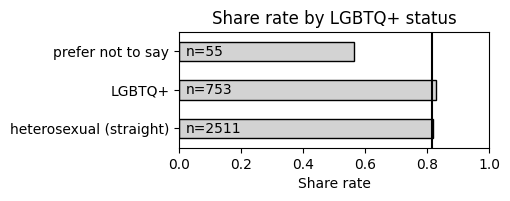

In [39]:
colname = 'LGBTQ+ status'
lgbtq_share_df = get_share_rate_by_Q_df(Q, colname)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(lgbtq_share_df)))
plot_share_by_demo(lgbtq_share_df, colname, ax)
lgbtq_share_df

,Q-sexual-orientation,n,share rate,LGBTQ+ status
0,1,499,0.804,heterosexual (straight)
1,2,151,0.821,LGBTQ+
2,3,8,0.625,prefer not to say


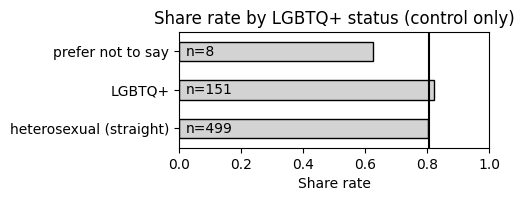

In [40]:
lgbtq_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(lgbtq_share_df)))
plot_share_by_demo(lgbtq_share_df, colname, ax, control_only=True)
lgbtq_share_df

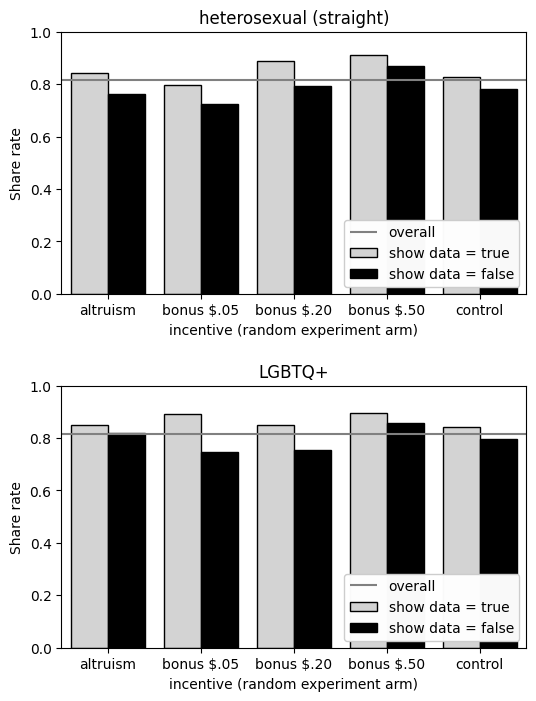

In [41]:
figsize=(6,4)
# exclude categories with N < 60
demo_df = demo_df[demo_df['count']>60]
fig,axes = plt.subplots(len(demo_df),1,figsize=(figsize[0],figsize[1]*len(demo_df)))
plt.subplots_adjust(hspace=0.35)
i = 0
for (k,v) in codebook[Q]['choices'].items():
    if v not in demo_df['index'].values:
        continue
    demo_agg_share_df = get_aggregate_share_df(df[df[Q]==k])
    #display(demo_agg_share_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(v)
    i += 1

### Race

Hypothesis: participants who identify as white-only will be more likely to share data

Note U.S. population ~75% white


Result:
- White participants more likely to share in control arm
- Other participants more likely to share in non-control arms

In [42]:
Q = 'Q-demos-race'
print('%s'%codebook[Q]['Q'])
print('%s'%codebook[Q]['choices'])
demo_df = (df[Q].value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
display(demo_df.sort_values('count', ascending=False))

Choose one or more races that you consider yourself to be
{'1': 'White', '2': 'Black or African American', '3': 'American Indian or Alaska Native', '4': 'Asian', '5': 'Native Hawaiian or Pacific Islander', '6': 'Other'}


,index,count,pct
0,White,2571,77.46
18,Asian,264,7.95
12,Black or African American,223,6.72
21,Other,64,1.93
9,"1,4",51,1.54
1,"1,2",39,1.18
6,"1,3",38,1.14
17,American Indian or Alaska Native,21,0.63
11,"1,6",13,0.39
2,"1,2,3",8,0.24


,white status,n,share rate
0,Otherwise,748,0.774
1,White only,2571,0.830


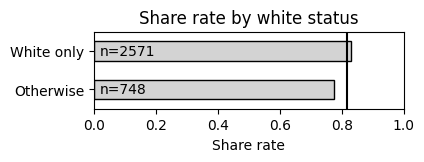

In [43]:
# Make column race where 1=white; 0=otherwise
colname = 'white status'
df[colname] = df[Q].apply(lambda r: 'White only' if r=='1' else 'Otherwise')
white_share_df = (
    df.groupby([colname])['share']
    .agg(['count','mean']).round(3).reset_index()
    .rename(columns={'count':'n', 'mean':'share rate'})
)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(white_share_df)))
plot_share_by_demo(white_share_df, colname, ax)
white_share_df 

,white status,n,share rate
0,Otherwise,151,0.748
1,White only,507,0.822


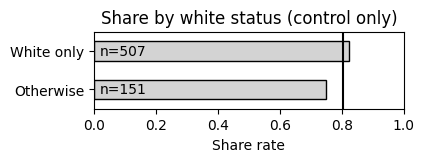

In [44]:
# For just control condition
control_df = get_control_df(df)
c_white_share_df = (
    control_df.groupby([colname])['share']
    .agg(['count','mean']).round(3).reset_index()
    .rename(columns={'count':'n', 'mean':'share rate'})
)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(white_share_df)))
plot_share_by_demo(c_white_share_df, colname, ax, control_only=True)
ax.set_title('Share by white status (control only)')
c_white_share_df 

,incentive,showdata,count,mean
0,altruism,false,250,0.788
1,altruism,true,270,0.837
2,bonus $.05,false,263,0.745
3,bonus $.05,true,254,0.815
4,bonus $.20,false,273,0.791
5,bonus $.20,true,250,0.880
6,bonus $.50,false,247,0.887
7,bonus $.50,true,257,0.914
8,control,false,242,0.785
9,control,true,265,0.857


,incentive,showdata,count,mean
0,altruism,false,84,0.702
1,altruism,true,76,0.855
2,bonus $.05,false,77,0.662
3,bonus $.05,true,62,0.774
4,bonus $.20,false,67,0.731
5,bonus $.20,true,76,0.842
6,bonus $.50,false,85,0.812
7,bonus $.50,true,70,0.871
8,control,false,72,0.778
9,control,true,79,0.722


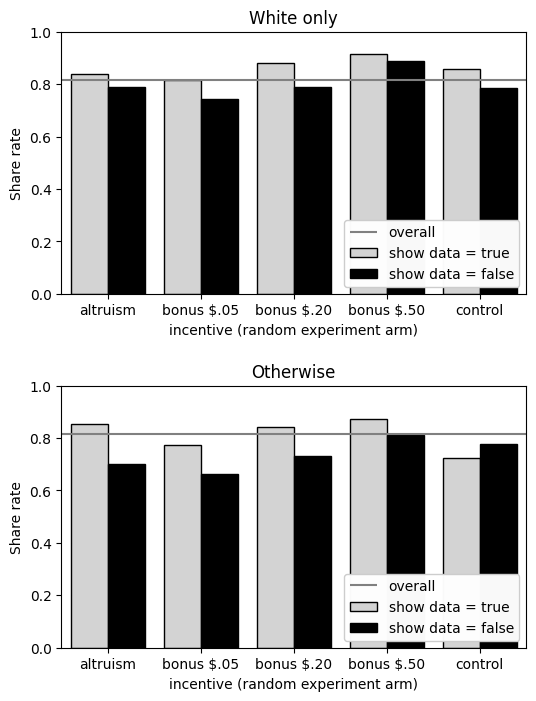

In [45]:
figsize=(6,4)
fig,axes = plt.subplots(2,1,figsize=(figsize[0],figsize[1]*2))
plt.subplots_adjust(hspace=0.35)
for i, r in enumerate(['White only', 'Otherwise']):
    demo_df = df[df[colname]==r]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    display(demo_agg_share_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(r)

### By purchase frequency

Finds:
- people who purchase less frequently more likely to share (have less to share?)

How often do you (+ anyone you share your account with) order deliveries from Amazon?
{'1': 'Less than 5 times per month', '2': '5 - 10 times per month', '3': 'More than 10 times per month'}


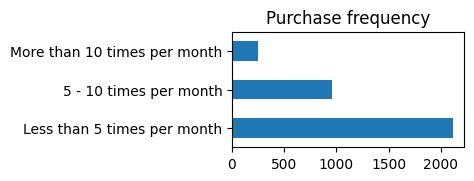

,index,count,pct
0,Less than 5 times per month,2119,63.84
1,5 - 10 times per month,953,28.71
2,More than 10 times per month,247,7.44


In [46]:
Q = 'Q-amazon-use-how-oft'
print('%s'%codebook[Q]['Q'])
print('%s'%codebook[Q]['choices'])
fig,ax = plt.subplots(figsize=(3,1.5))
_ = df[Q].value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
ax.set_title('Purchase frequency')
plt.show()
demo_df = (df[Q].value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
display(demo_df)

,Q-amazon-use-how-oft,n,share rate,purchase frequency
0,1,2119,0.817,Less than 5 times per month
1,2,953,0.816,5 - 10 times per month
2,3,247,0.822,More than 10 times per month


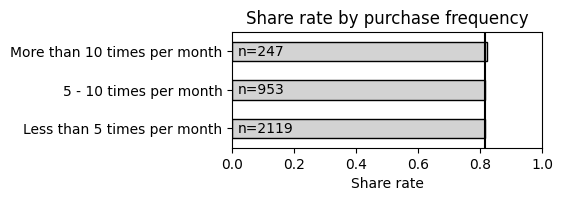

In [47]:
colname = 'purchase frequency'
pf_share_df = get_share_rate_by_Q_df(Q, colname)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(pf_share_df)))
plot_share_by_demo(pf_share_df, colname, ax)
pf_share_df

,Q-amazon-use-how-oft,n,share rate,purchase frequency
0,1,419,0.831,Less than 5 times per month
1,2,192,0.745,5 - 10 times per month
2,3,47,0.830,More than 10 times per month


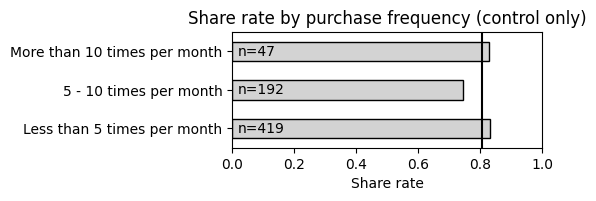

In [48]:
colname = 'purchase frequency'
pf_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(pf_share_df)))
plot_share_by_demo(pf_share_df, colname, ax, control_only=True)
pf_share_df

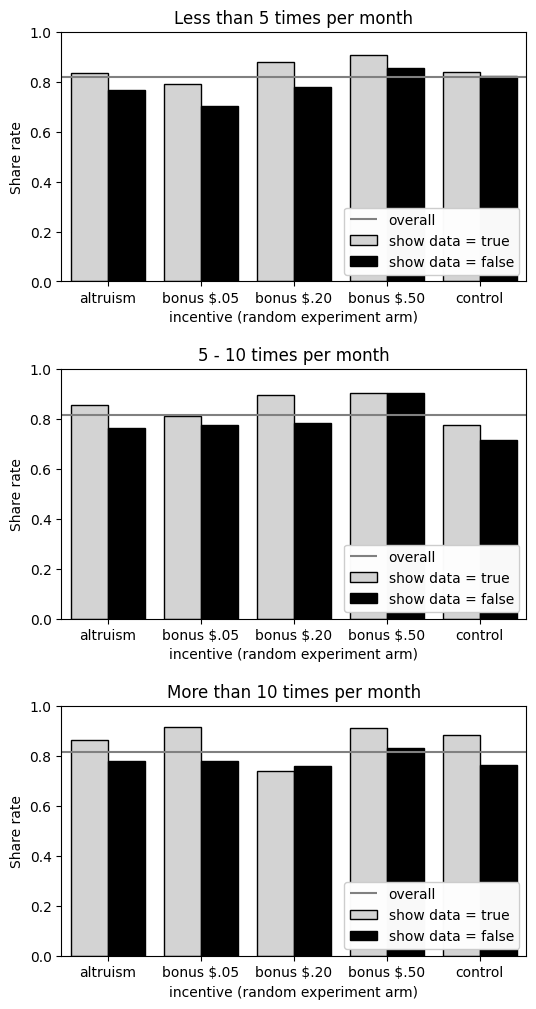

In [49]:
figsize=(6,4)
choices = codebook[Q]['choices']
fig,axes = plt.subplots(len(choices),1,figsize=(figsize[0],figsize[1]*len(choices)))
plt.subplots_adjust(hspace=0.35)
for i, (k,v) in enumerate(codebook[Q]['choices'].items()):
    demo_df = df[df[Q]==k]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    #display(demo_agg_share_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(v)

### Real vs hypothetical

On average, how does the hypothetical amount of money participants *say they would* accept in exchange for their data compare to the amount that participants *do accept* as bonus payment for their data, when presented with the real opportunity?
Hypothesis: on average participants are willing to accept a lower amount than they report they would in the hypothetical scenario.


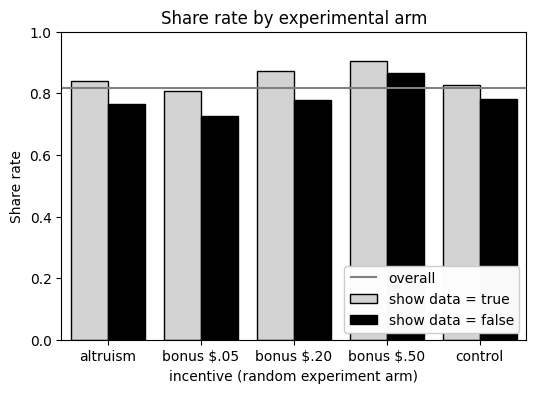

In [50]:
fig,ax = plt.subplots(1,1, figsize=(6,4))#, dpi=300)
ax.set_title('Share rate by experimental arm')
plot_share_rate(agg_share_df, ax)

In [51]:
# take just the participants in the control arm who answered no

control_no_share_df = df[(df['incentive']=='control') & (df['share']==0)]
control_no_share_showdata1_df = control_no_share_df[control_no_share_df['showdata']=='true']
control_no_share_showdata0_df = control_no_share_df[control_no_share_df['showdata']=='false']
print('n=%s participants in incentive:control arm who did not share data' % len(control_no_share_df))
print('n=%s participants in incentive:control, showdata:true arm who did not share data' 
      % len(control_no_share_showdata1_df))
print('n=%s participants in incentive:control, showdata:false arm who did not share data' 
      % len(control_no_share_showdata0_df))
# control_no_share_df.head()

n=128 participants in incentive:control arm who did not share data
n=60 participants in incentive:control, showdata:true arm who did not share data
n=68 participants in incentive:control, showdata:false arm who did not share data


In [52]:
# data value Qs
data_value_Qs = [
    'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
    'Q-data-value-100', 'Q-data-value-any', 'Q-data-value-any_1_TEXT'
]
control_no_share_df[data_value_Qs].head()

,Q-data-value-05,Q-data-value-20,Q-data-value-50,Q-data-value-100,Q-data-value-any,Q-data-value-any_1_TEXT
18,0,0,0,0,1,30.00
56,0,0,0,0,1,50
81,0,1,NaN,NaN,NaN,NaN
133,0,0,1,NaN,NaN,NaN
144,0,0,0,0,0,NaN


First focus on just showdata=true

What is the difference in the share rate for incentive=$0.50 vs control?

Count everyone in the control group that did not share their data, who said they would hypothetically share their data for value of \\$0.05, \\$0.20, or \$0.50

In [53]:
control_showdata1_share_rate = agg_share_df.set_index(
    ['incentive','showdata']
).loc[('control','true')]['mean']
print('control share rate:', control_showdata1_share_rate)
bonus50_showdata1_share_rate = agg_share_df.set_index(
    ['incentive','showdata']
).loc[('bonus $.50','true')]['mean']
print('bonus $.50 share rate:', bonus50_showdata1_share_rate)
share_rate_diff = bonus50_showdata1_share_rate - control_showdata1_share_rate
print('share rate difference: %0.2f' % share_rate_diff)

control share rate: 0.826
bonus $.50 share rate: 0.905
share rate difference: 0.08


Here's the approach taken below:

(restricted to showdata=true)

- (a) We compute the fraction of people who would *truly share* for \$0.50 or less
- (b) We compute the fraction of people who *say they would hypothetically share* for \$0.50 or less

We compare (a) and (b)

We compute these quantities as follows:

(a)
For people in the experiment arm: bonus $0.50

- We count the number of people who shared their data.
- And the number of people who did not share their data.
- We compute the fraction

(b)
We consider the experiment arm: control equivalent to offering $0.

For people in the experiment arm: control
- we count the number of people who did share
- and the number of people who did not share but then said they would hypothetically share for either \\$0.05, \\$0.20, \\$0.50
- we add these quantities and consider this the number of people who would hypothetically share for $0.50 or less
- we count the number of people who did not share and would not hypothetically share for \$0.50 or less
- we compute the fraction

(We know there is a problem with this way of thinking about this, because our results show that people in the control arm are more likely to share their data than people offered \$0.05.)


Make a table:

control_shares:

```
amount, share count, cumulative share count, total count, cumulative share rate

```

In [54]:
s1 = df[(df['incentive']=='control') & (df['showdata']=='true')][[
    'share',
    'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
    'Q-data-value-100', 'Q-data-value-any'
]]
# rename columns to represent amounts offered
s1.columns=['$0','$0.05','$0.20','$0.50','$1.00','> $1.00']
s1.head(3)

,$0,$0.05,$0.20,$0.50,$1.00,> $1.00
18,0.0,0,0,0,0,1
23,1.0,NaN,NaN,NaN,NaN,NaN
28,1.0,NaN,NaN,NaN,NaN,NaN


In [55]:
control_showdata1_shares_df = (s1.astype(float).fillna(0).apply(sum)
                               .to_frame(name='share count'))
control_showdata1_shares_df.index.names = ['amount']
control_showdata1_shares_df['cumulative count'] = control_showdata1_shares_df['share count'].cumsum()
control_showdata1_shares_df['total'] = len(s1)
control_showdata1_shares_df['cumulative share rate'] = (
    control_showdata1_shares_df['cumulative count']/control_showdata1_shares_df['total']
).round(3)
control_showdata1_shares_df

,share count,cumulative count,total,cumulative share rate
amount,,,,
$0,284.0,284.0,344,0.826
$0.05,9.0,293.0,344,0.852
$0.20,1.0,294.0,344,0.855
$0.50,4.0,298.0,344,0.866
$1.00,4.0,302.0,344,0.878
> $1.00,32.0,334.0,344,0.971


Compare this to:

In [56]:
real_shares_showdata1 = (
    agg_share_df.set_index(['showdata','incentive'])
    .loc['true']
    .rename(columns={'mean':'share rate'})
    .rename({'control':'$0', 'bonus $.05':'$0.05', 'bonus $.20':'$0.20', 'bonus $.50':'$0.50'})
    .loc[['$0', '$0.05', '$0.20', '$0.50']]
)
real_shares_showdata1

,count,share rate
incentive,,
$0,344,0.826
$0.05,316,0.807
$0.20,326,0.871
$0.50,327,0.905


Do the same for showdata=false

In [57]:
control_showdata0_share_rate = agg_share_df.set_index(
    ['incentive','showdata']
).loc[('control','false')]['mean']
print('control share rate:', control_showdata0_share_rate)
bonus50_showdata0_share_rate = agg_share_df.set_index(
    ['incentive','showdata']
).loc[('bonus $.50','false')]['mean']
print('bonus $.50 share rate:', bonus50_showdata0_share_rate)
share_rate_diff = bonus50_showdata0_share_rate - control_showdata0_share_rate
print('share rate difference: %0.2f' % share_rate_diff)

control share rate: 0.783
bonus $.50 share rate: 0.867
share rate difference: 0.08


In [58]:
s0 = df[(df['incentive']=='control') & (df['showdata']=='false')][[
    'share',
    'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
    'Q-data-value-100', 'Q-data-value-any'
]]
# rename columns to represent amounts offered
s0.columns=['$0','$0.05','$0.20','$0.50','$1.00','> $1.00']
control_showdata0_shares_df = (s0.astype(float).fillna(0).apply(sum)
                               .to_frame(name='share count'))
control_showdata0_shares_df.index.names = ['amount']
control_showdata0_shares_df['cumulative count'] = control_showdata0_shares_df['share count'].cumsum()
control_showdata0_shares_df['total'] = len(s0)
control_showdata0_shares_df['cumulative share rate'] = (
    control_showdata0_shares_df['cumulative count']/control_showdata0_shares_df['total']
).round(3)
control_showdata0_shares_df

,share count,cumulative count,total,cumulative share rate
amount,,,,
$0,246.0,246.0,314,0.783
$0.05,6.0,252.0,314,0.803
$0.20,2.0,254.0,314,0.809
$0.50,2.0,256.0,314,0.815
$1.00,10.0,266.0,314,0.847
> $1.00,32.0,298.0,314,0.949


In [59]:
print('compare to:')
real_shares_showdata0 = (
    agg_share_df.set_index(['showdata','incentive'])
    .loc['false']
    .rename(columns={'mean':'share rate'})
    .rename({'control':'$0', 'bonus $.05':'$0.05', 'bonus $.20':'$0.20', 'bonus $.50':'$0.50'})
    .loc[['$0', '$0.05', '$0.20', '$0.50']]
)
real_shares_showdata0

compare to:


,count,share rate
incentive,,
$0,314,0.783
$0.05,340,0.726
$0.20,340,0.779
$0.50,332,0.867


If this seems like the right kind of comparison to make, result:

When looking at \$0.50 incentive:
- people more likely to actually share (a) vs say they would share (b)
- for both showdata=true,showdata=false
- (hypothesis confirmed)

This is also the case for the \$0.20 incentive

But when looking at \\$0.05 incentive, this is not the case
- for both showdata=true, showdata=false: Fewer people actually share than say they would share 

Plot it

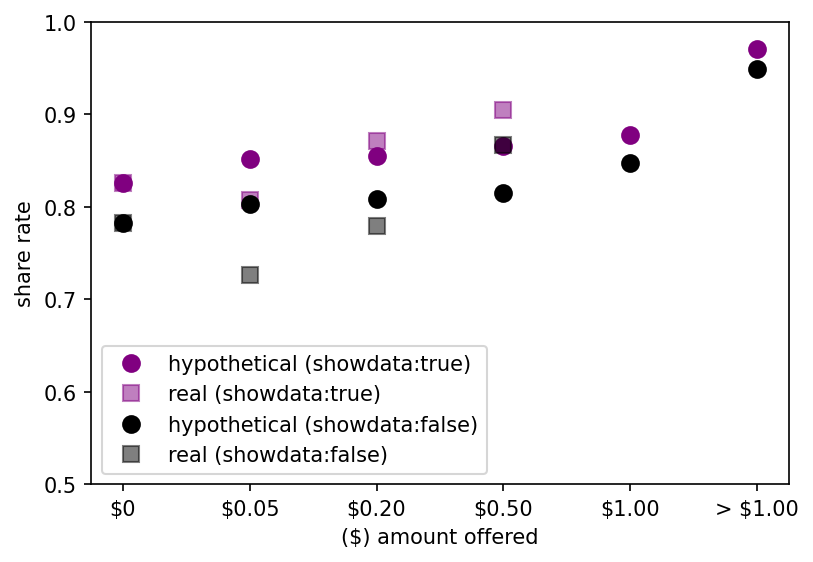

In [74]:
black_alpha = 0.5
fig,ax = plt.subplots(1,1, figsize=(6,4), dpi=150)
# showdata:true
ax.plot(control_showdata1_shares_df['cumulative share rate'], 
        'o',#--', 
        color='purple', markersize=8,
       label='hypothetical (showdata:true)')
ax.plot(real_shares_showdata1['share rate'], 
        's',#-', 
        alpha=black_alpha,
        color='purple', markersize=8,
       label='real (showdata:true)')

ax.plot(control_showdata0_shares_df['cumulative share rate'], 
        'o',#--', 
        color='black', markersize=8,
       label='hypothetical (showdata:false)')
ax.plot(real_shares_showdata0['share rate'], 
        's',#-', 
        alpha=black_alpha,
        color='black', markersize=8,
       label='real (showdata:false)')
ax.set_ylim([0.5,1])
ax.set_ylabel('share rate')
ax.set_xlabel('($) amount offered')
_ = ax.legend()

# Questions about data use

At the end of the survey we ask:

- Do you think Amazon should be able to sell YOUR purchase data to other companies?
- Do you think companies should be able to sell consumer purchase data to other companies?
- Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?
- Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?
- Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?

The order of these questions is randomized.

In [61]:
data_use_Qs = {
    'Q-sell-YOUR-data': {
        'Q':'Do you think Amazon should be able to sell YOUR purchase data to other companies?',
        'choices': {'1': 'Yes','2':'No','3':'Yes if I get part of the profit','4':"I don't know"},
    },
    'Q-sell-consumer-data': {
        'Q':'Do you think companies should be able to sell consumer purchase data to other companies?',
        'choices': {'1': 'Yes','2':'No','3':'Yes if consumers get part of the profit','4':"I don't know"},
    },
    'Q-small-biz-use': {
        'Q':'Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?',
        'choices': {'1': 'Yes','2':'No','3':"I don't know"},
    },
    'Q-census-use': {
        'Q':'Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?',
        'choices': {'1': 'Yes','2':'No','3':"I don't know"},
    },
    'Q-research-society': {
        'Q':'Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?',
        'choices': {'1': 'Yes','2':'No','3':"I don't know"},
    }, 
}

Overall what were the answers to these questions?

Do you think Amazon should be able to sell YOUR purchase data to other companies?


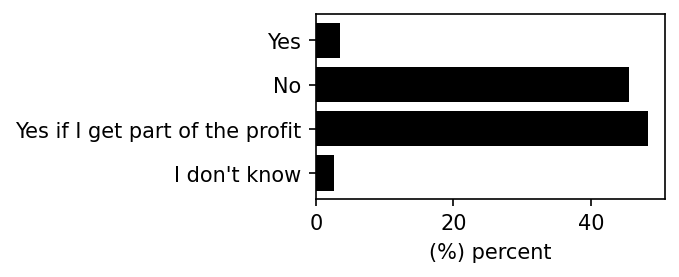

Do you think companies should be able to sell consumer purchase data to other companies?


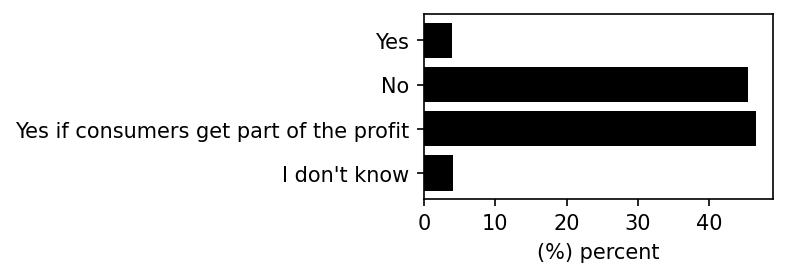

Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?


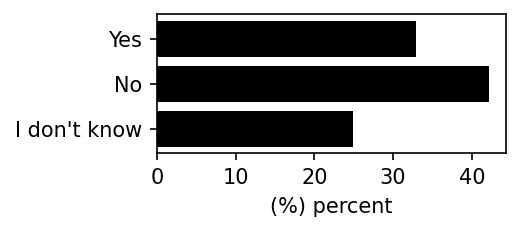

Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?


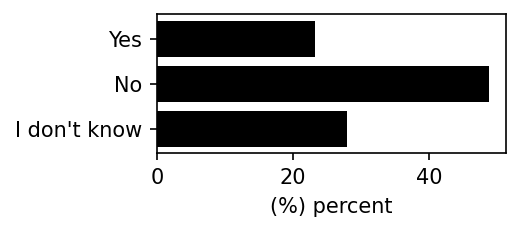

Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?


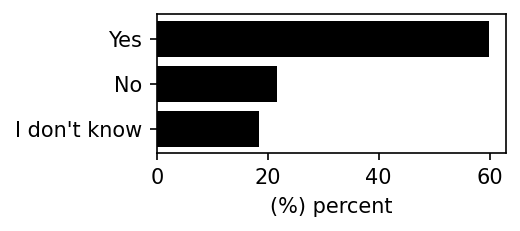

In [62]:
Q = 'Q-sell-YOUR-data'
for Q in data_use_Qs.keys():
    answers_df = (df[Q].value_counts()
              .sort_index(ascending=False).rename(data_use_Qs[Q]['choices'])
              .to_frame(name='count')
              .assign(pct=lambda x: round(100*x['count']/N, 2)))
    print(data_use_Qs[Q]['Q'])
    fig,ax = plt.subplots(1,1, figsize=(3,0.4*len(answers_df)), dpi=150)
    ax.set_xlabel('(%) percent')
    ax.barh(answers_df.index, answers_df['pct'], color='black')
    #display(answers_df)
    plt.show()

How do the answers differ by whether participant shared?

Do you think Amazon should be able to sell YOUR purchase data to other companies?


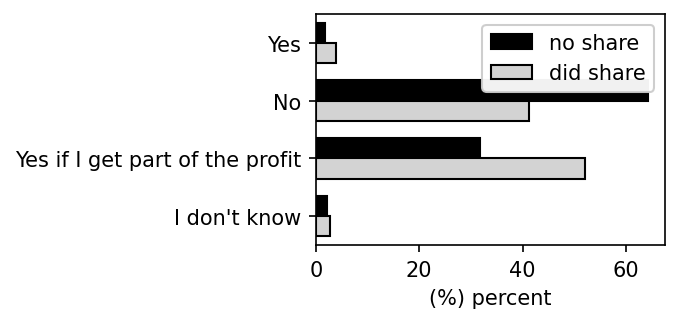

Do you think companies should be able to sell consumer purchase data to other companies?


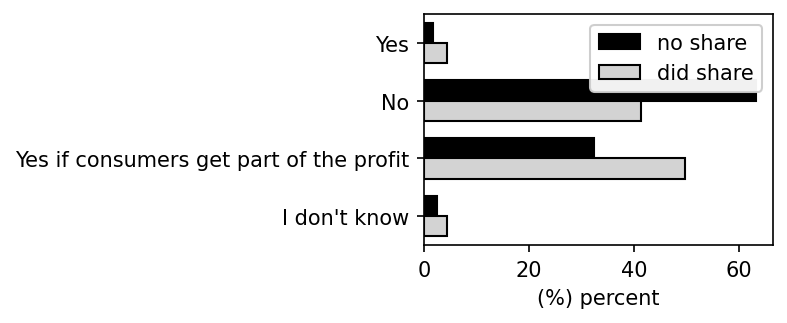

Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?


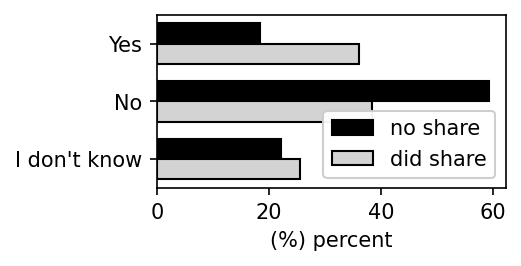

Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?


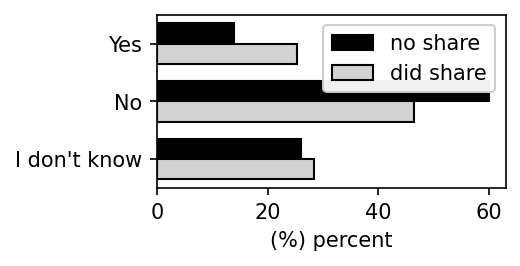

Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?


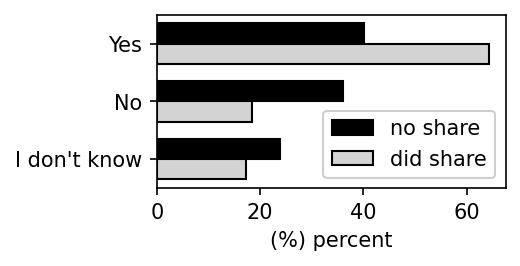

In [63]:
no_share_df = df[df['share']==0]
yes_share_df = df[df['share']==1]
for Q in data_use_Qs.keys():
    n_choices = len(data_use_Qs[Q]['choices'])
    print(data_use_Qs[Q]['Q'])
    fig,ax = plt.subplots(1,1,figsize=(3,0.5*n_choices), dpi=150)
    a0_df = (no_share_df[Q].value_counts()
                  .sort_index(ascending=False).rename(data_use_Qs[Q]['choices'])
                  .to_frame(name='count')
                  .assign(pct=lambda x: round(100*x['count']/len(no_share_df), 2)))
    a1_df = (yes_share_df[Q].value_counts()
                  .sort_index(ascending=False).rename(data_use_Qs[Q]['choices'])
                  .to_frame(name='count')
                  .assign(pct=lambda x: round(100*x['count']/len(yes_share_df), 2)))
    width = 0.35
    a0_df['pct'].plot(
        kind='barh', ax=ax, color='black', edgecolor='black', 
        width=width, position=0, label='no share'
    )
    a1_df['pct'].plot(
        kind='barh', ax=ax, color='lightgray', edgecolor='black', 
        width=width, position=1, label='did share'
    )
    ax.set_xlabel('(%) percent')
    ax.set_ylim([-0.5,(n_choices - 0.5)])
    ax.legend(facecolor='white', framealpha=0.95)#, loc='upper right')
    plt.show()
#     display(a0_df)
#     display(a1_df)

#### Did the random assignment to an experimental arm impact the participants' responses to these questions?

For each question, make a separate plot for each response, separating by incentive on the x-axis.

In [64]:
def plot_answer_rate(pdf, ax, N, overall_rate=None):
    width = 0.4
    (pdf[pdf['showdata']=='true']['pct']
     .plot(
        kind='barh', color='lightgray', edgecolor='black',
        label='show data = true',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']=='false']['pct']
     .plot(
        kind='barh', color='black', 
        edgecolor='black', 
        label='show data = false',
        ax=ax, width=width, position=0)
    )
    ax.set_xlabel('Answer rate (N=%s)' % N)
    ax.set_ylim([-0.5,4.5])
    #ax.set_xlim([0,1])
    _ = ax.set_yticklabels(pdf[pdf['showdata']=='true']['incentive'])

Do you think Amazon should be able to sell YOUR purchase data to other companies?


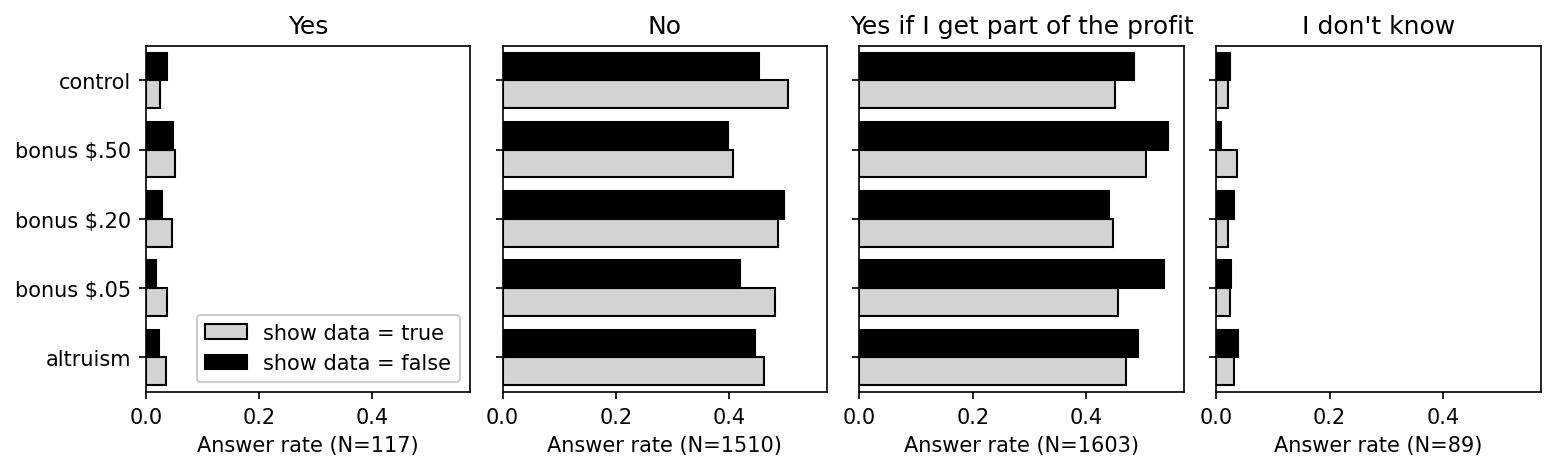

Do you think companies should be able to sell consumer purchase data to other companies?


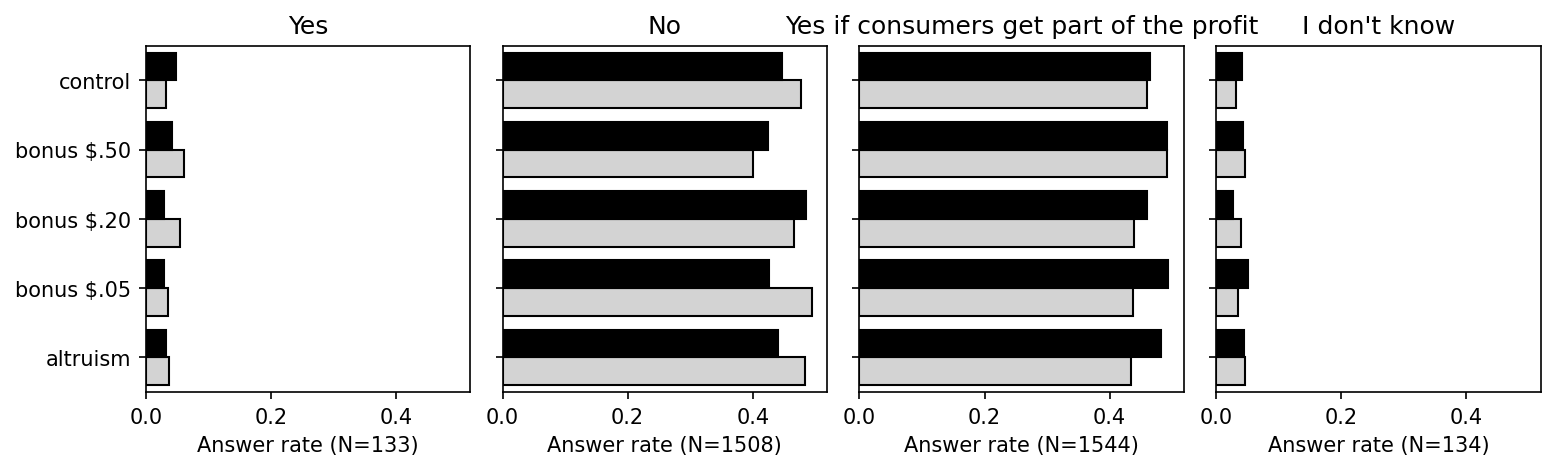

Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?


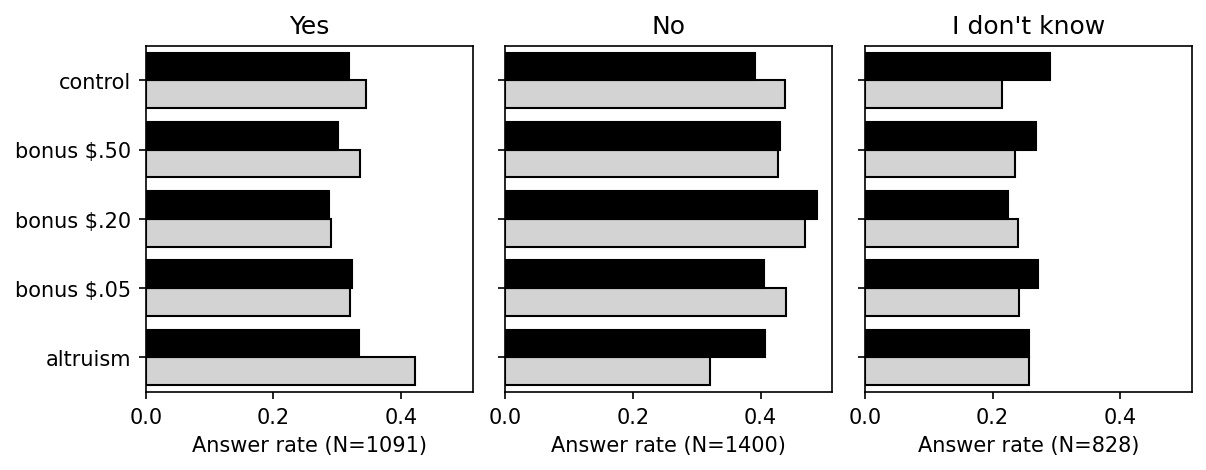

Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?


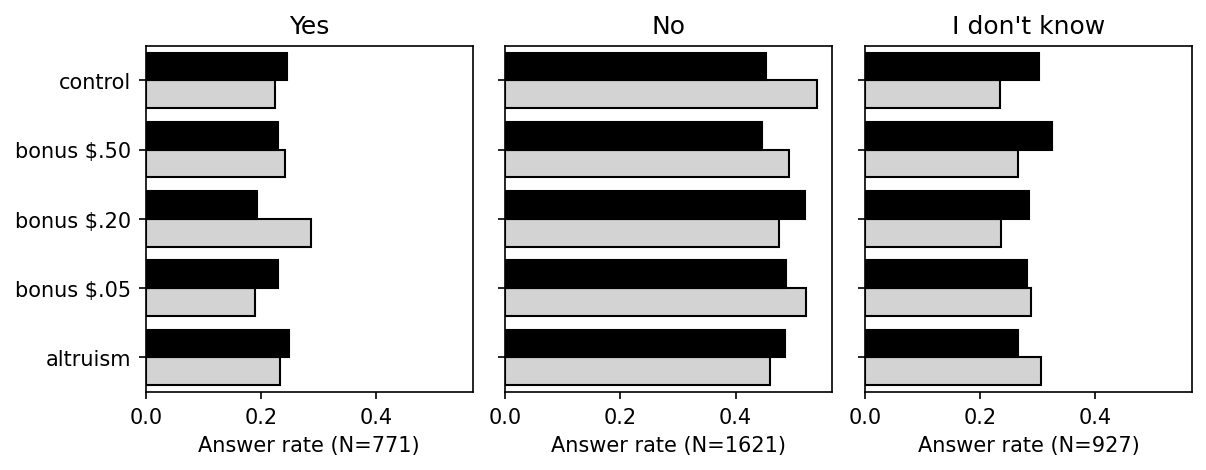

Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?


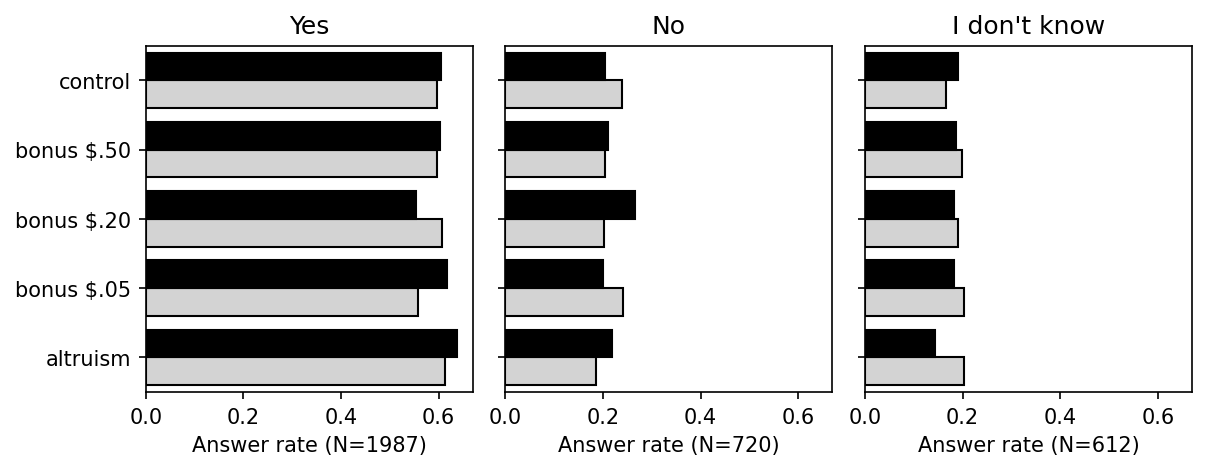

In [65]:
for q, Q in enumerate(data_use_Qs.keys()):
    n_choices = len(data_use_Qs[Q]['choices'])
    #print(Q)
    print(data_use_Qs[Q]['Q'])
    fig,axes = plt.subplots(1,n_choices,figsize=(3*n_choices,3), sharex=True, sharey=True, dpi=150)
    plt.subplots_adjust(wspace=0.1)
    for i, (choice_code, choice_text) in enumerate(data_use_Qs[Q]['choices'].items()):
        ax = axes[i]
        c_df = df[(df[Q]==choice_code)]
        c_N = len(c_df)
        ax.set_title('%s' % (choice_text))
        #print(i, choice_text)
        #print('N=%s'%c_N)
        c_by_exp_arm_df = (
            c_df.groupby(['incentive','showdata'])['ResponseId'].agg(['count'])
             .merge(
                df.groupby(['incentive','showdata'])['ResponseId'].agg(['count']),
                on=['incentive', 'showdata'],
                how='outer', suffixes=["","_all"]
             ).reset_index()
             .assign(pct=lambda x: (x['count']/x['count_all']).round(3)))
        #display(c_by_exp_arm_df)
        plot_answer_rate(c_by_exp_arm_df, ax, c_N)
        if q==0 and i==0:
            ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    plt.show()

Do you think Amazon should be able to sell YOUR purchase data to other companies?


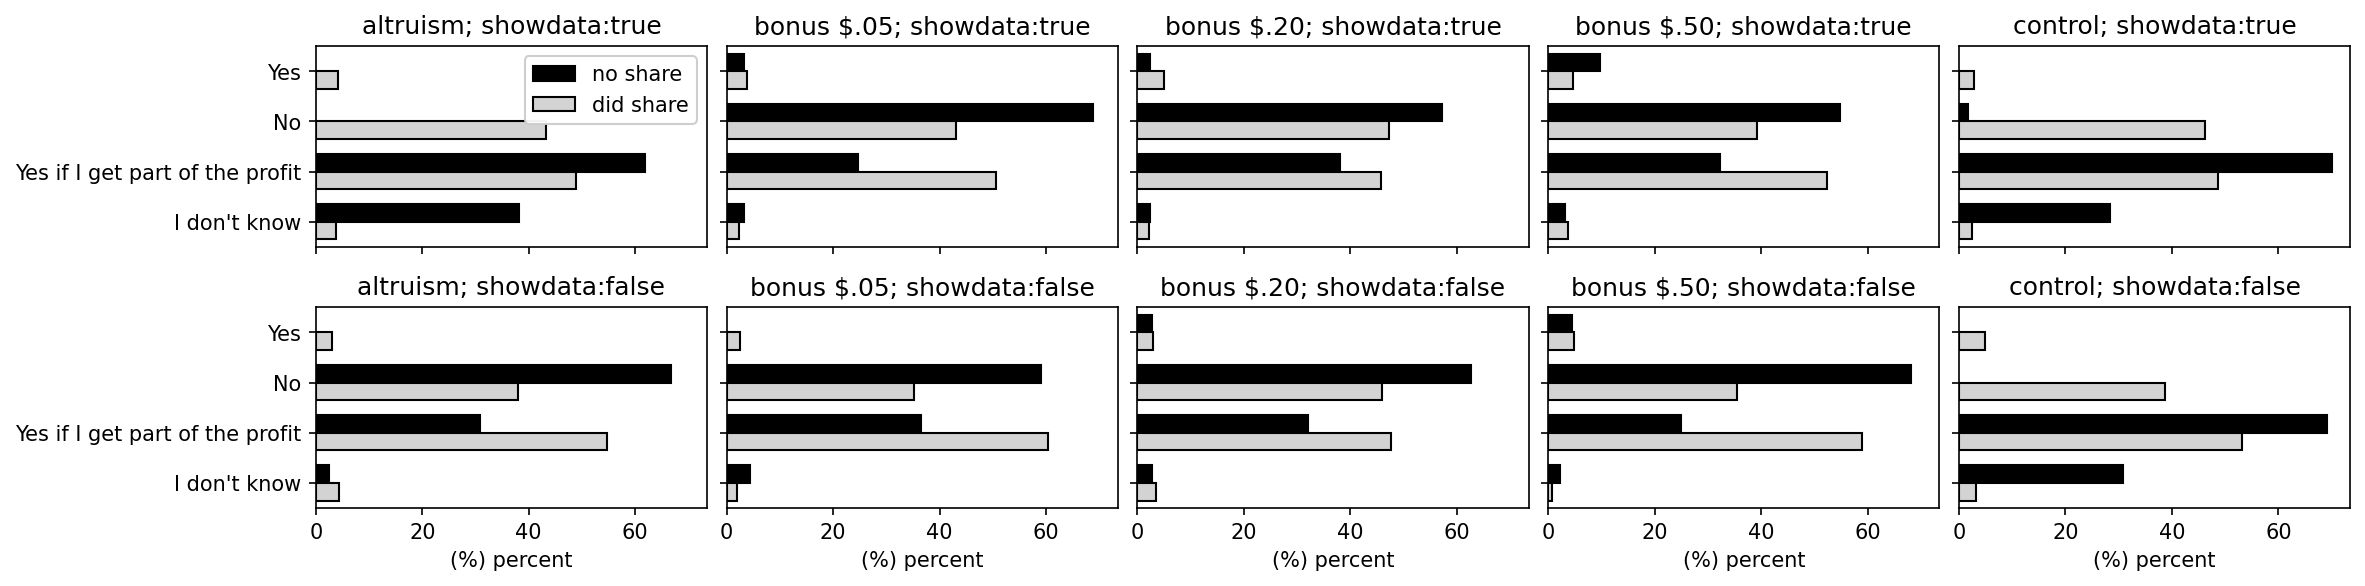

Do you think companies should be able to sell consumer purchase data to other companies?


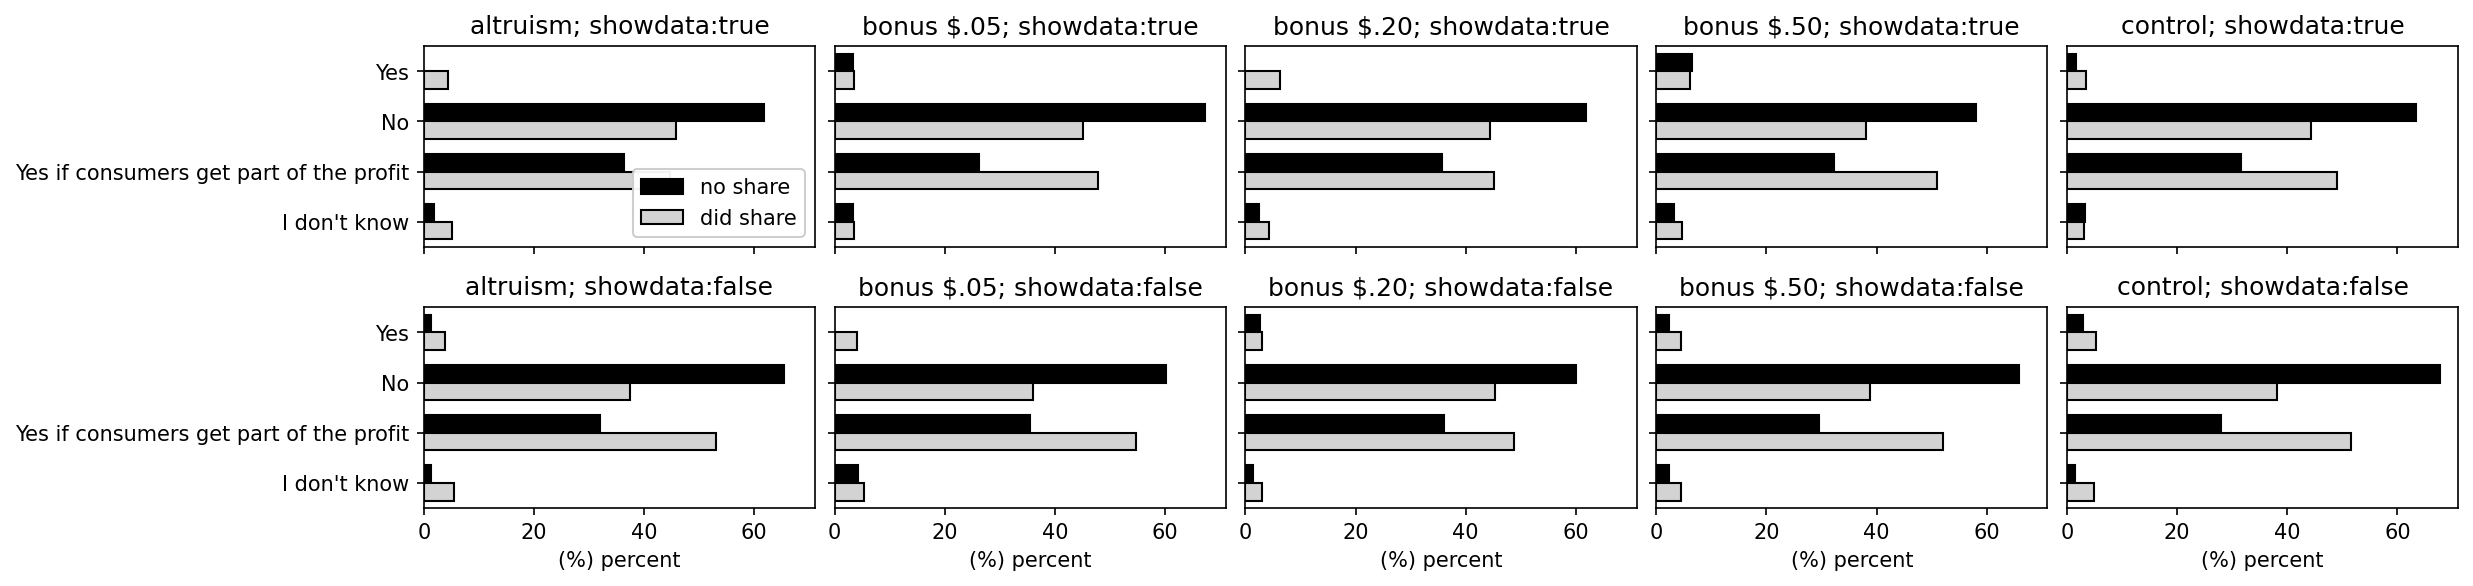

Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?


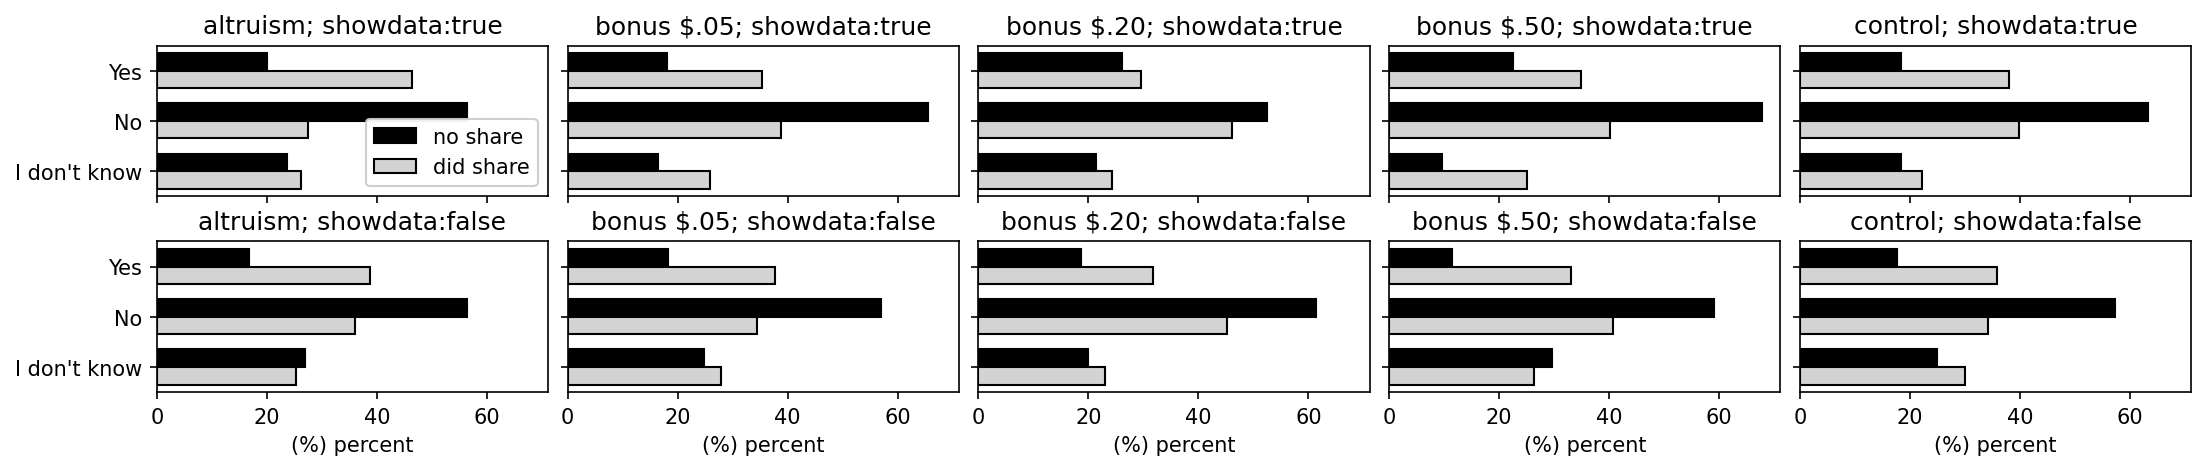

Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?


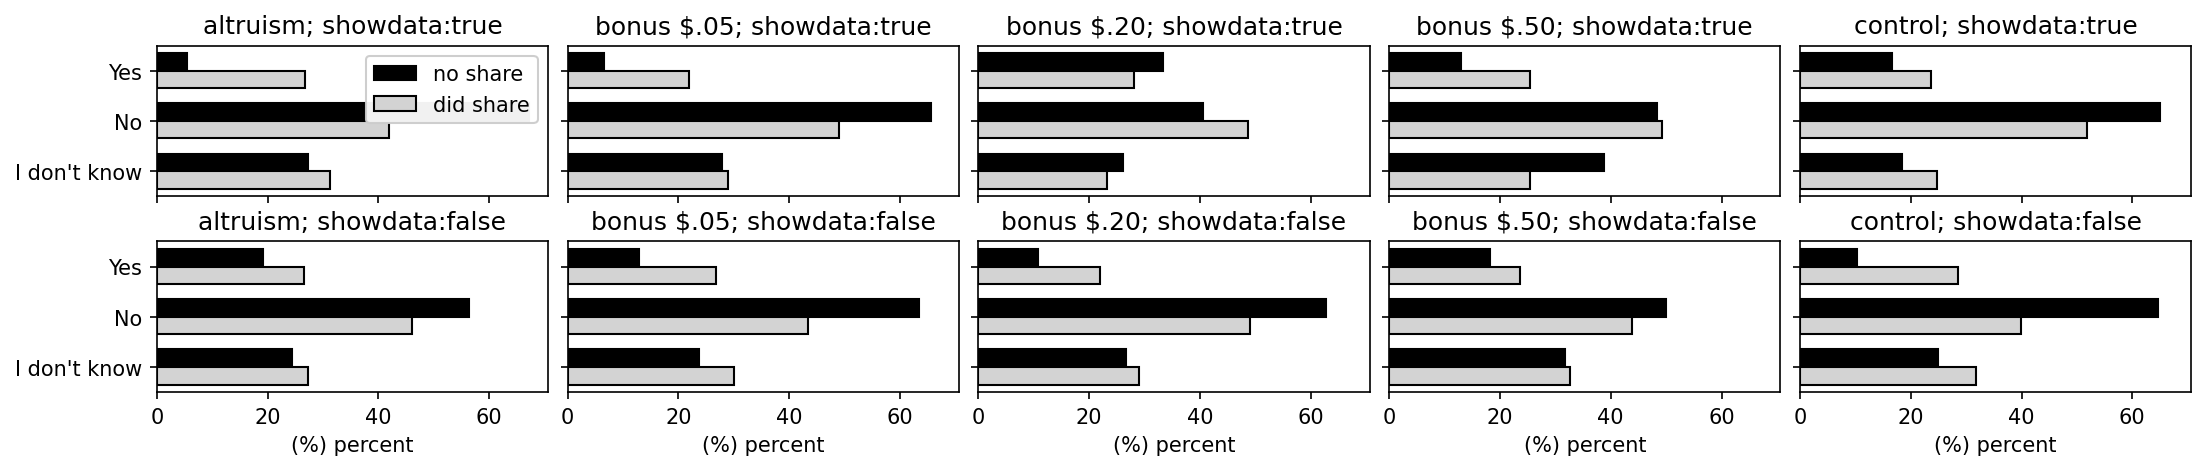

Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?


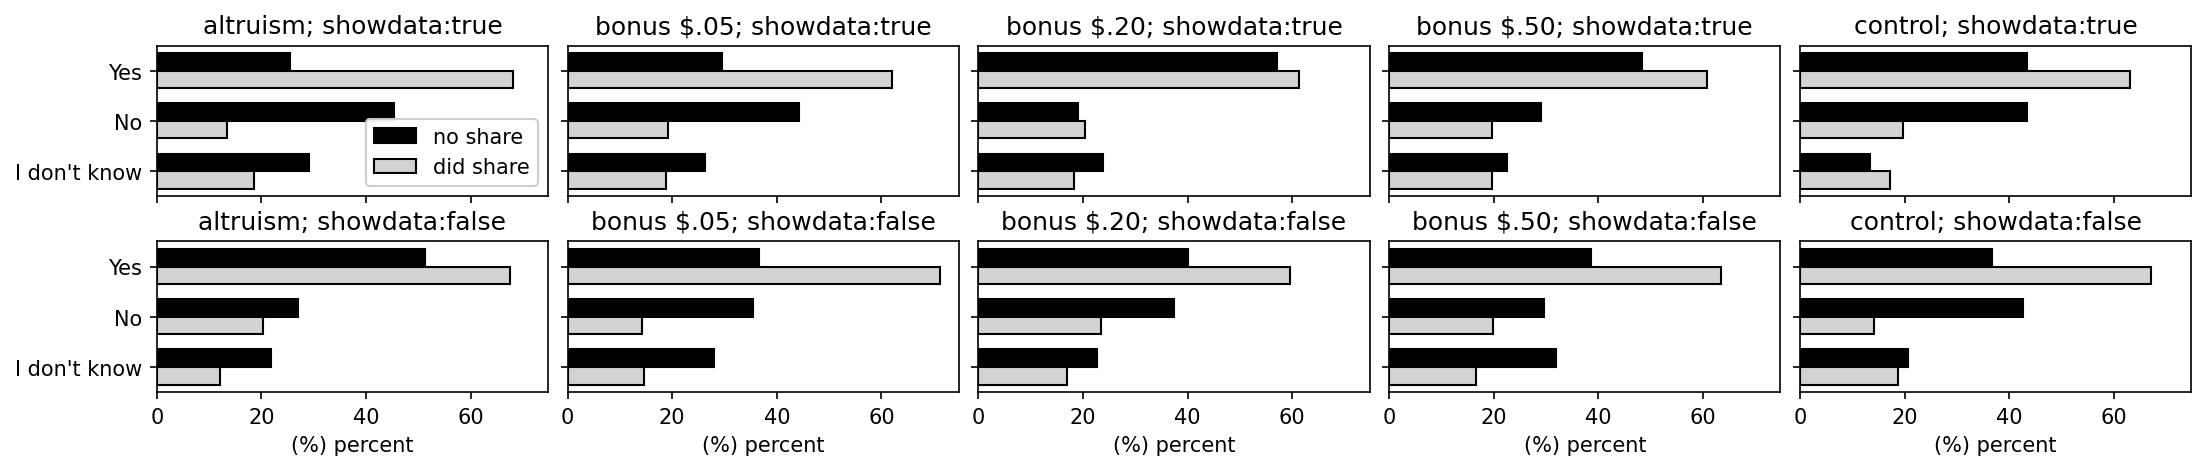

In [66]:
# by experimental arm

no_share_df = df[df['share']==0]
yes_share_df = df[df['share']==1]
for Q in data_use_Qs.keys():
    n_choices = len(data_use_Qs[Q]['choices'])
    print(data_use_Qs[Q]['Q'])
    fig,axes = plt.subplots(2,5,figsize=(5*3.5,2*0.5*n_choices),sharey=True,sharex=True, dpi=150)
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    for i, showdata in enumerate(['true','false']):
        for j, incentive in enumerate(sorted(df['incentive'].unique())):
            ax = axes[i][j]
            a0_df = (no_share_df[(
                (no_share_df['showdata']==showdata) & (no_share_df['incentive']==incentive)
            )][Q].value_counts()
                          .sort_index(ascending=False).rename(data_use_Qs[Q]['choices'])
                          .to_frame(name='count'))
            a0_df['pct'] = (100*a0_df['count']/a0_df['count'].sum()).round(2)
            a1_df = (yes_share_df[
                ((yes_share_df['showdata']==showdata) & (yes_share_df['incentive']==incentive))
            ][Q].value_counts()
                          .sort_index(ascending=False).rename(data_use_Qs[Q]['choices'])
                          .to_frame(name='count'))
            a1_df['pct'] = (100*a1_df['count']/a1_df['count'].sum()).round(2)
            width = 0.35
            a0_df['pct'].plot(
                kind='barh', ax=ax, color='black', edgecolor='black', 
                width=width, position=0, label='no share'
            )
            a1_df['pct'].plot(
                kind='barh', ax=ax, color='lightgray', edgecolor='black', 
                width=width, position=1, label='did share'
            )
            ax.set_xlabel('(%) percent')
            ax.set_ylim([-0.5,(n_choices - 0.5)])
            if i==0 and j==0:
                ax.legend(facecolor='white', framealpha=0.95)#, loc='upper right')
            ax.set_title('%s; showdata:%s' % (incentive, showdata))
            #     display(a0_df)
            #     display(a1_df)
    plt.show()

Do you think Amazon should be able to sell YOUR purchase data to other companies?


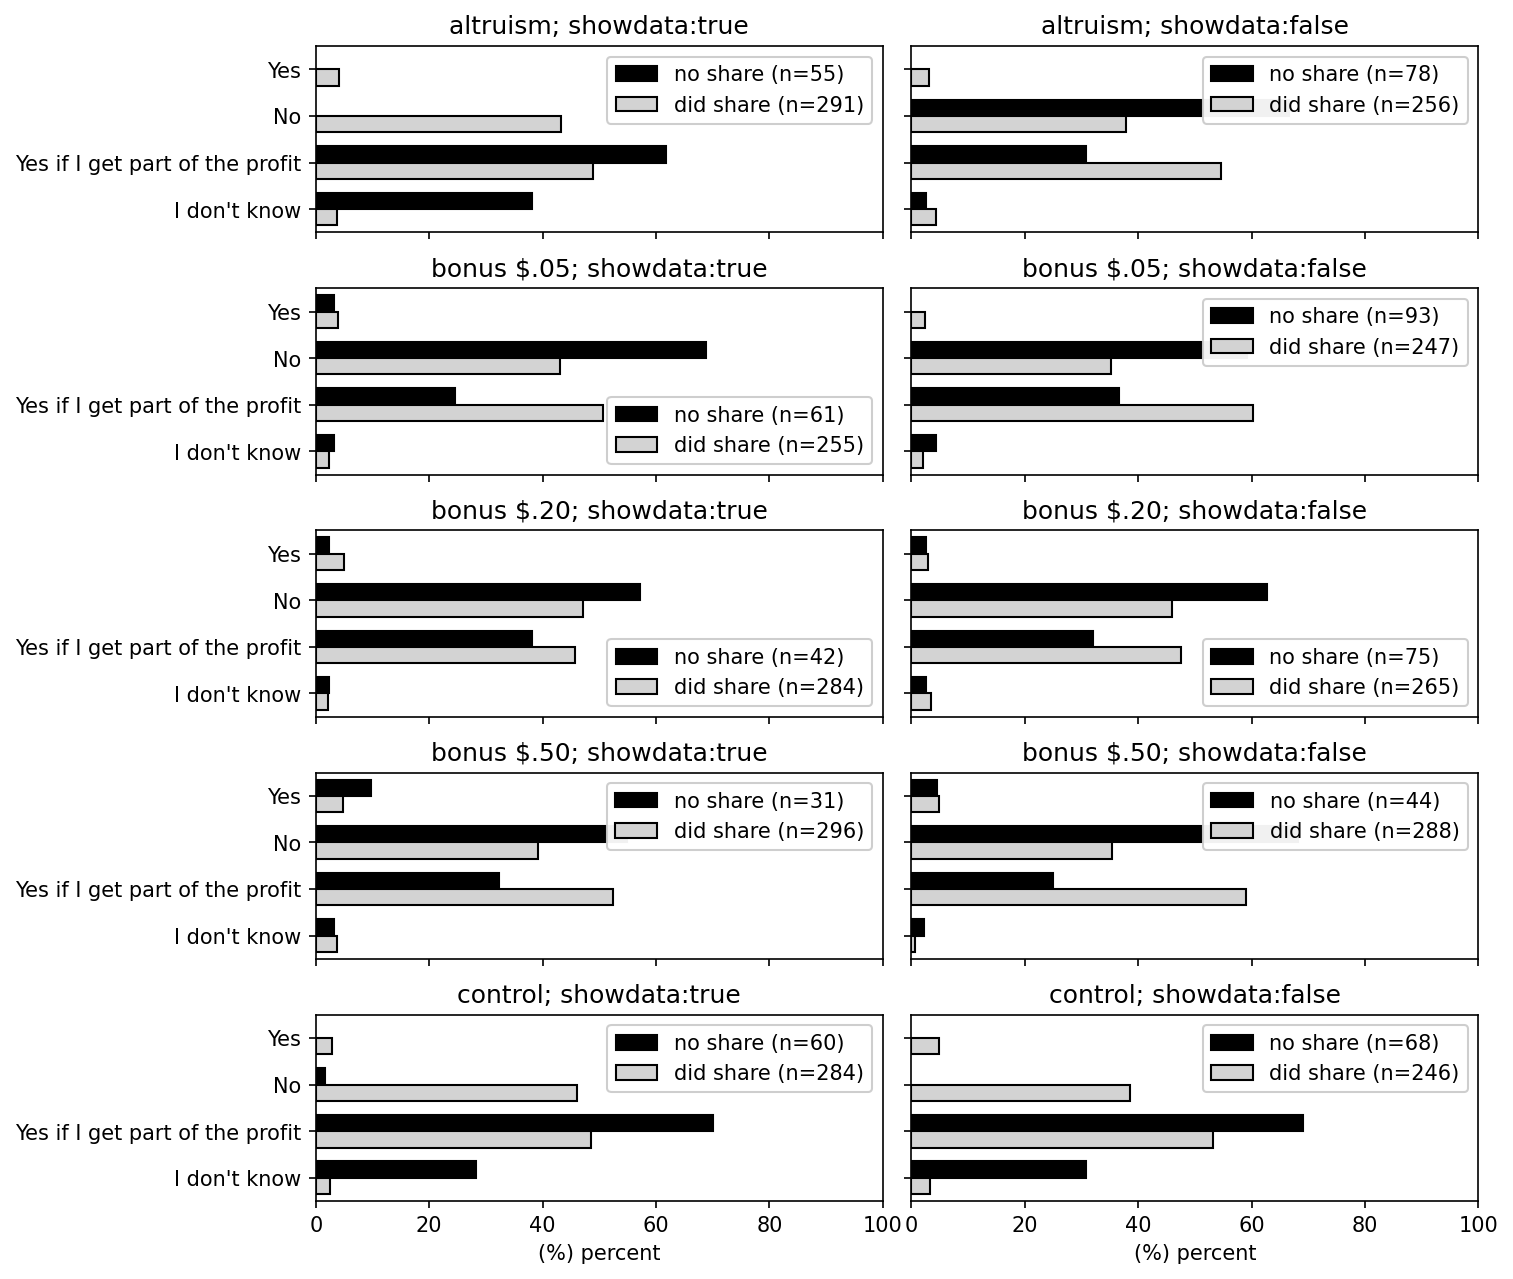

Do you think companies should be able to sell consumer purchase data to other companies?


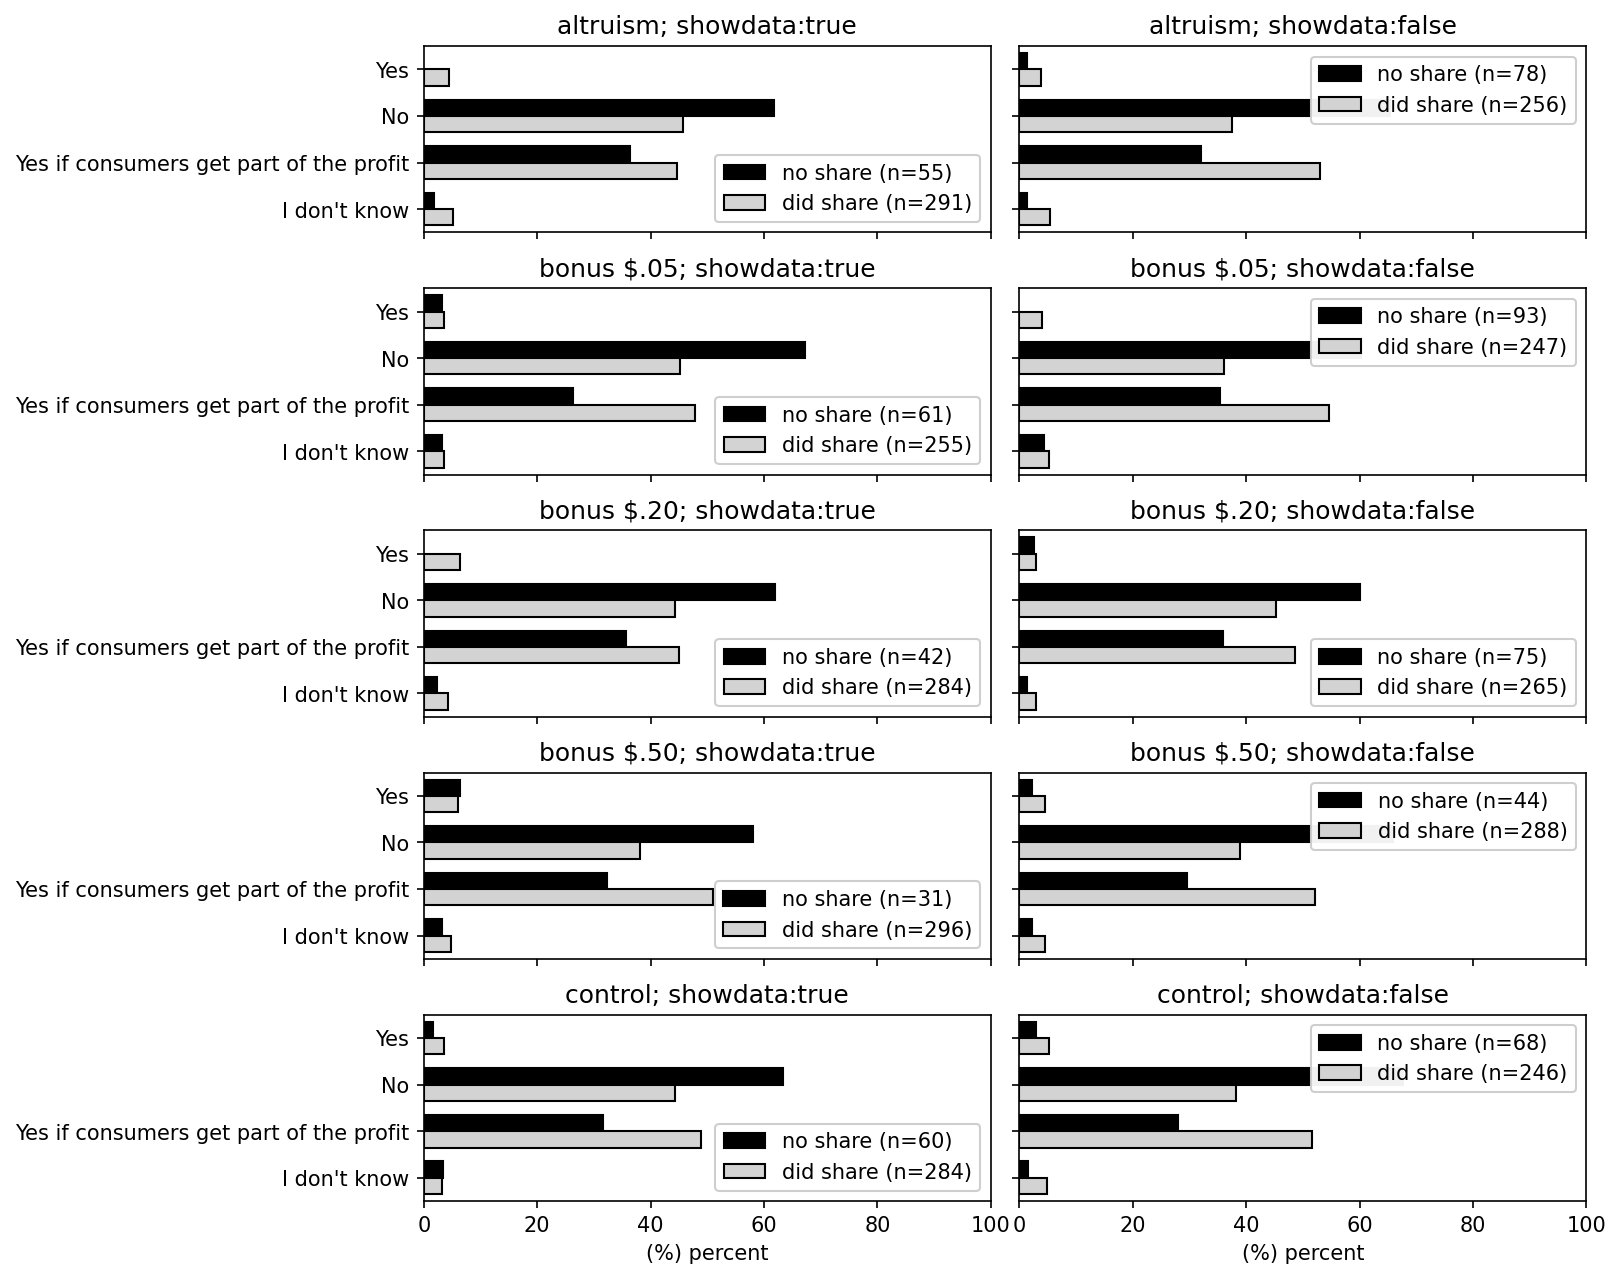

Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?


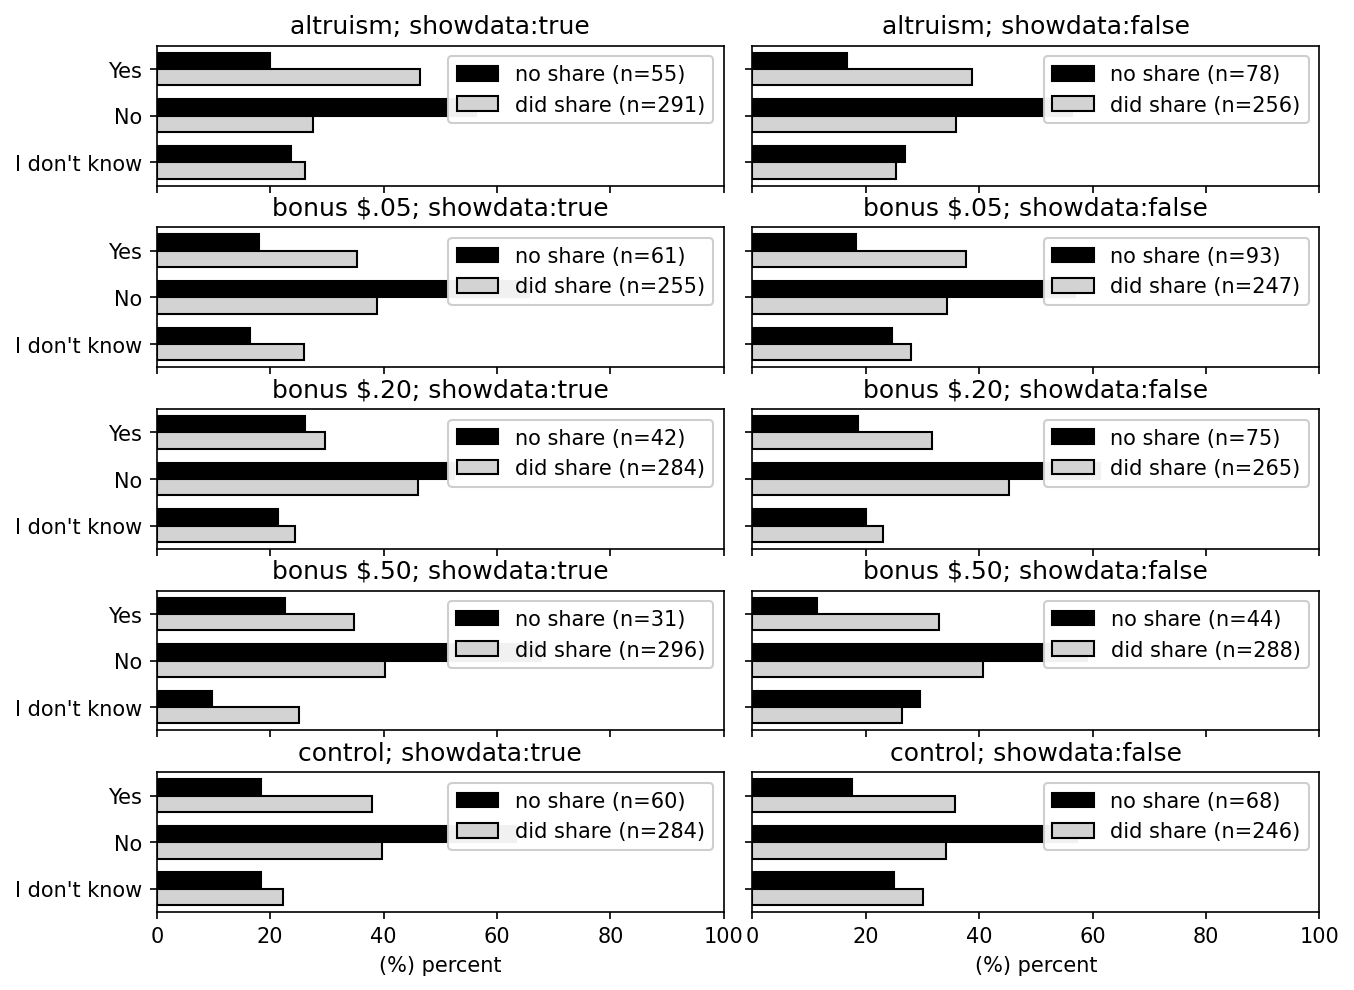

Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?


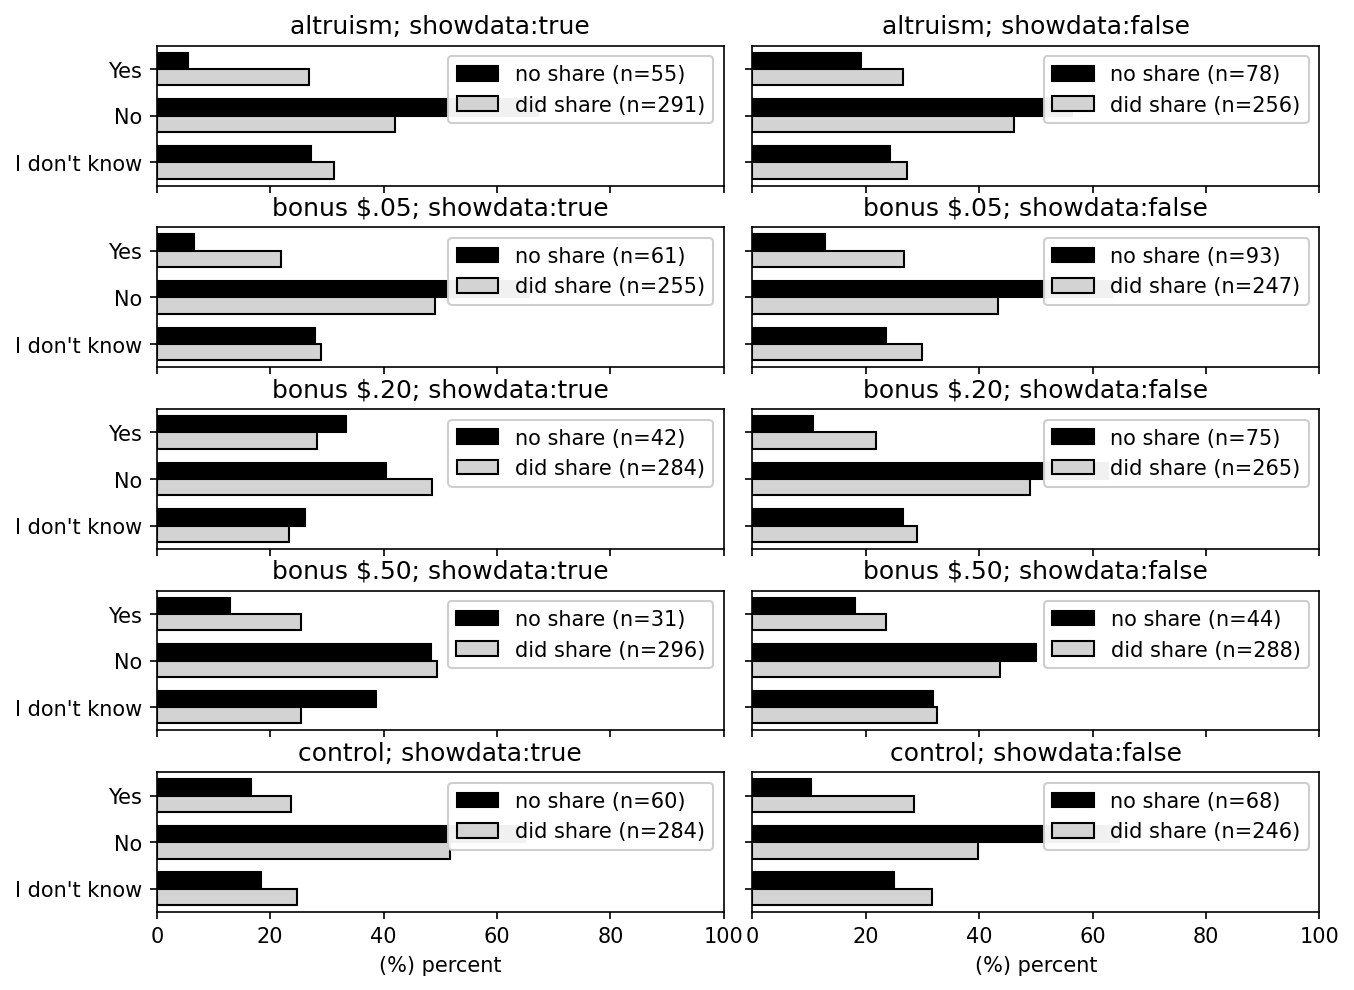

Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?


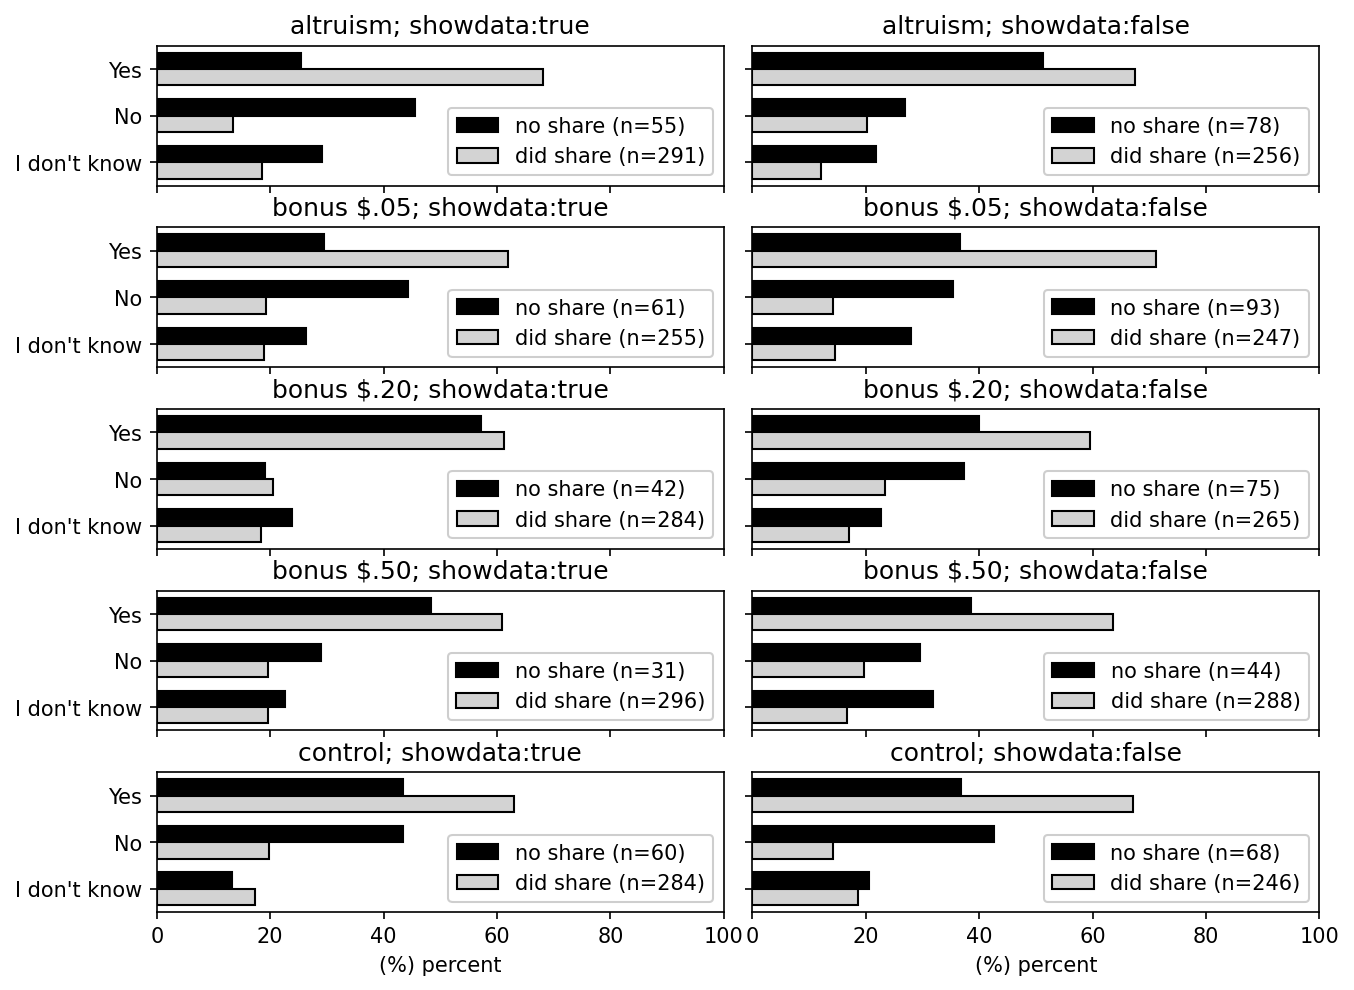

In [67]:
# show same as above but in the other orientation
# by experimental arm

no_share_df = df[df['share']==0]
yes_share_df = df[df['share']==1]
for Q in data_use_Qs.keys():
    n_choices = len(data_use_Qs[Q]['choices'])
    print(data_use_Qs[Q]['Q'])
    fig,axes = plt.subplots(5,2,figsize=(2*5, 5*0.5*n_choices),sharey=True,sharex=True, dpi=150)
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    for j, incentive in enumerate(sorted(df['incentive'].unique())):
        for i, showdata in enumerate(['true','false']):
            ax = axes[j][i]
            a0 = no_share_df[(
                (no_share_df['showdata']==showdata) & (no_share_df['incentive']==incentive)
            )]
            a0_df = (a0[Q].value_counts()
                          .sort_index(ascending=False).rename(data_use_Qs[Q]['choices'])
                          .to_frame(name='count'))
            a0_df['pct'] = (100*a0_df['count']/a0_df['count'].sum()).round(2)
            a1 = yes_share_df[
                ((yes_share_df['showdata']==showdata) & (yes_share_df['incentive']==incentive))
            ]
            a1_df = (a1[Q].value_counts()
                          .sort_index(ascending=False).rename(data_use_Qs[Q]['choices'])
                          .to_frame(name='count'))
            a1_df['pct'] = (100*a1_df['count']/a1_df['count'].sum()).round(2)
            width = 0.35
            a0_df['pct'].plot(
                kind='barh', ax=ax, color='black', edgecolor='black', 
                width=width, position=0, label='no share (n=%s)'%len(a0)
            )
            a1_df['pct'].plot(
                kind='barh', ax=ax, color='lightgray', edgecolor='black', 
                width=width, position=1, label='did share (n=%s)'%len(a1)
            )
            ax.set_xlabel('(%) percent')
            ax.set_xlim([0,100])
            ax.set_ylim([-0.5,(n_choices - 0.5)])
            ax.legend(facecolor='white', framealpha=0.95)#, loc='upper right')
            ax.set_title('%s; showdata:%s' % (incentive, showdata))
            #     display(a0_df)
            #     display(a1_df)
    plt.show()

In [68]:
d = df[(df['incentive']=='control')&(df['Q-research-society']=='2')&(df['share']==1)]
d['Q-sell-YOUR-data'].value_counts().rename(data_use_Qs['Q-sell-YOUR-data']['choices'])

No                                 67
Yes if I get part of the profit    24
Name: Q-sell-YOUR-data, dtype: int64

In [69]:
d['Q-sell-consumer-data'].value_counts().rename(data_use_Qs['Q-sell-consumer-data']['choices'])

No                                         65
Yes if consumers get part of the profit    25
Yes                                         1
Name: Q-sell-consumer-data, dtype: int64

# Comments

In [71]:
print('%s comments' % len(df['Q-comments'].dropna().values))
for c in df['Q-comments'].dropna().values:
    print('--------')
    print(c)

410 comments
--------
I recently became part of the Amazon Vine Voices program.
--------
this was interesting 
--------
None
--------
No
--------
those 2 gift cards for video games was when my account got HACKED. Never got a refund for them either. The mouse I got (the fancy one) got stolen and had to be resent. I usually use it for sending gifts.
--------
thanks
--------
I redacted my address, name, zip code, and credit card information from the excel sheet I sent in. I made sure to keep everything you said you needed for the survey. Thanks!
--------
I promise I'm not as freaky as my order history would suggest.
--------
none
--------
I hope I did this correctly!
--------
A bonus of like $1 or more would be highly appreciated compared to 5 cents
--------
pay a real bonus
--------
very annoying
--------
none
--------
I would have liked to have been presented with more questions about data sharing. Perhaps ones that contrast US policies with those in other countries, the EU for example.